In [1]:
%run -i 'preamble.py'

import logging


logging.getLogger('matplotlib').setLevel(logging.ERROR)

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

# import preamble
from src.constants import COLOR_MAPS, PATH_VOCAB_EMBEDDED, EMBEDDING_MODEL, PATH_MIGRATION_SPEECHES_EMBEDDED

In [2]:
df = pd.read_parquet(PATH_MIGRATION_SPEECHES_EMBEDDED)
print(f"#Samples: {len(df)}")

#Samples: 9705


# Party / Block Embeddings

First thing we would like to do is to derive party embeddings from individual speech embeddings.
Because our selected model uses mean pooling to construct text embeddings most straightforward way of doing this would be to do late mean pooling

## Mean pooling

In [3]:
def get_aggregated_embeddings_for_each_year(df: pd.DataFrame, embedding_column: str, aggregate_on: str):
    yearly_data = df.copy()
    yearly_data['year'] = pd.to_datetime(df['date']).dt.year
    aggregated_embeddings = yearly_data.groupby(by=[aggregate_on, 'year'])[embedding_column].agg(lambda emb: np.stack(emb).mean(axis=0) )
    return aggregated_embeddings.reset_index()


In [4]:
aggregate_on = "block"
aggregated = get_aggregated_embeddings_for_each_year(df, EMBEDDING_MODEL, "block")

Firs thing we want to see is how much parties embeddings change over the years. We can measure it by computing cosine distance between current and previous year's party embeddings

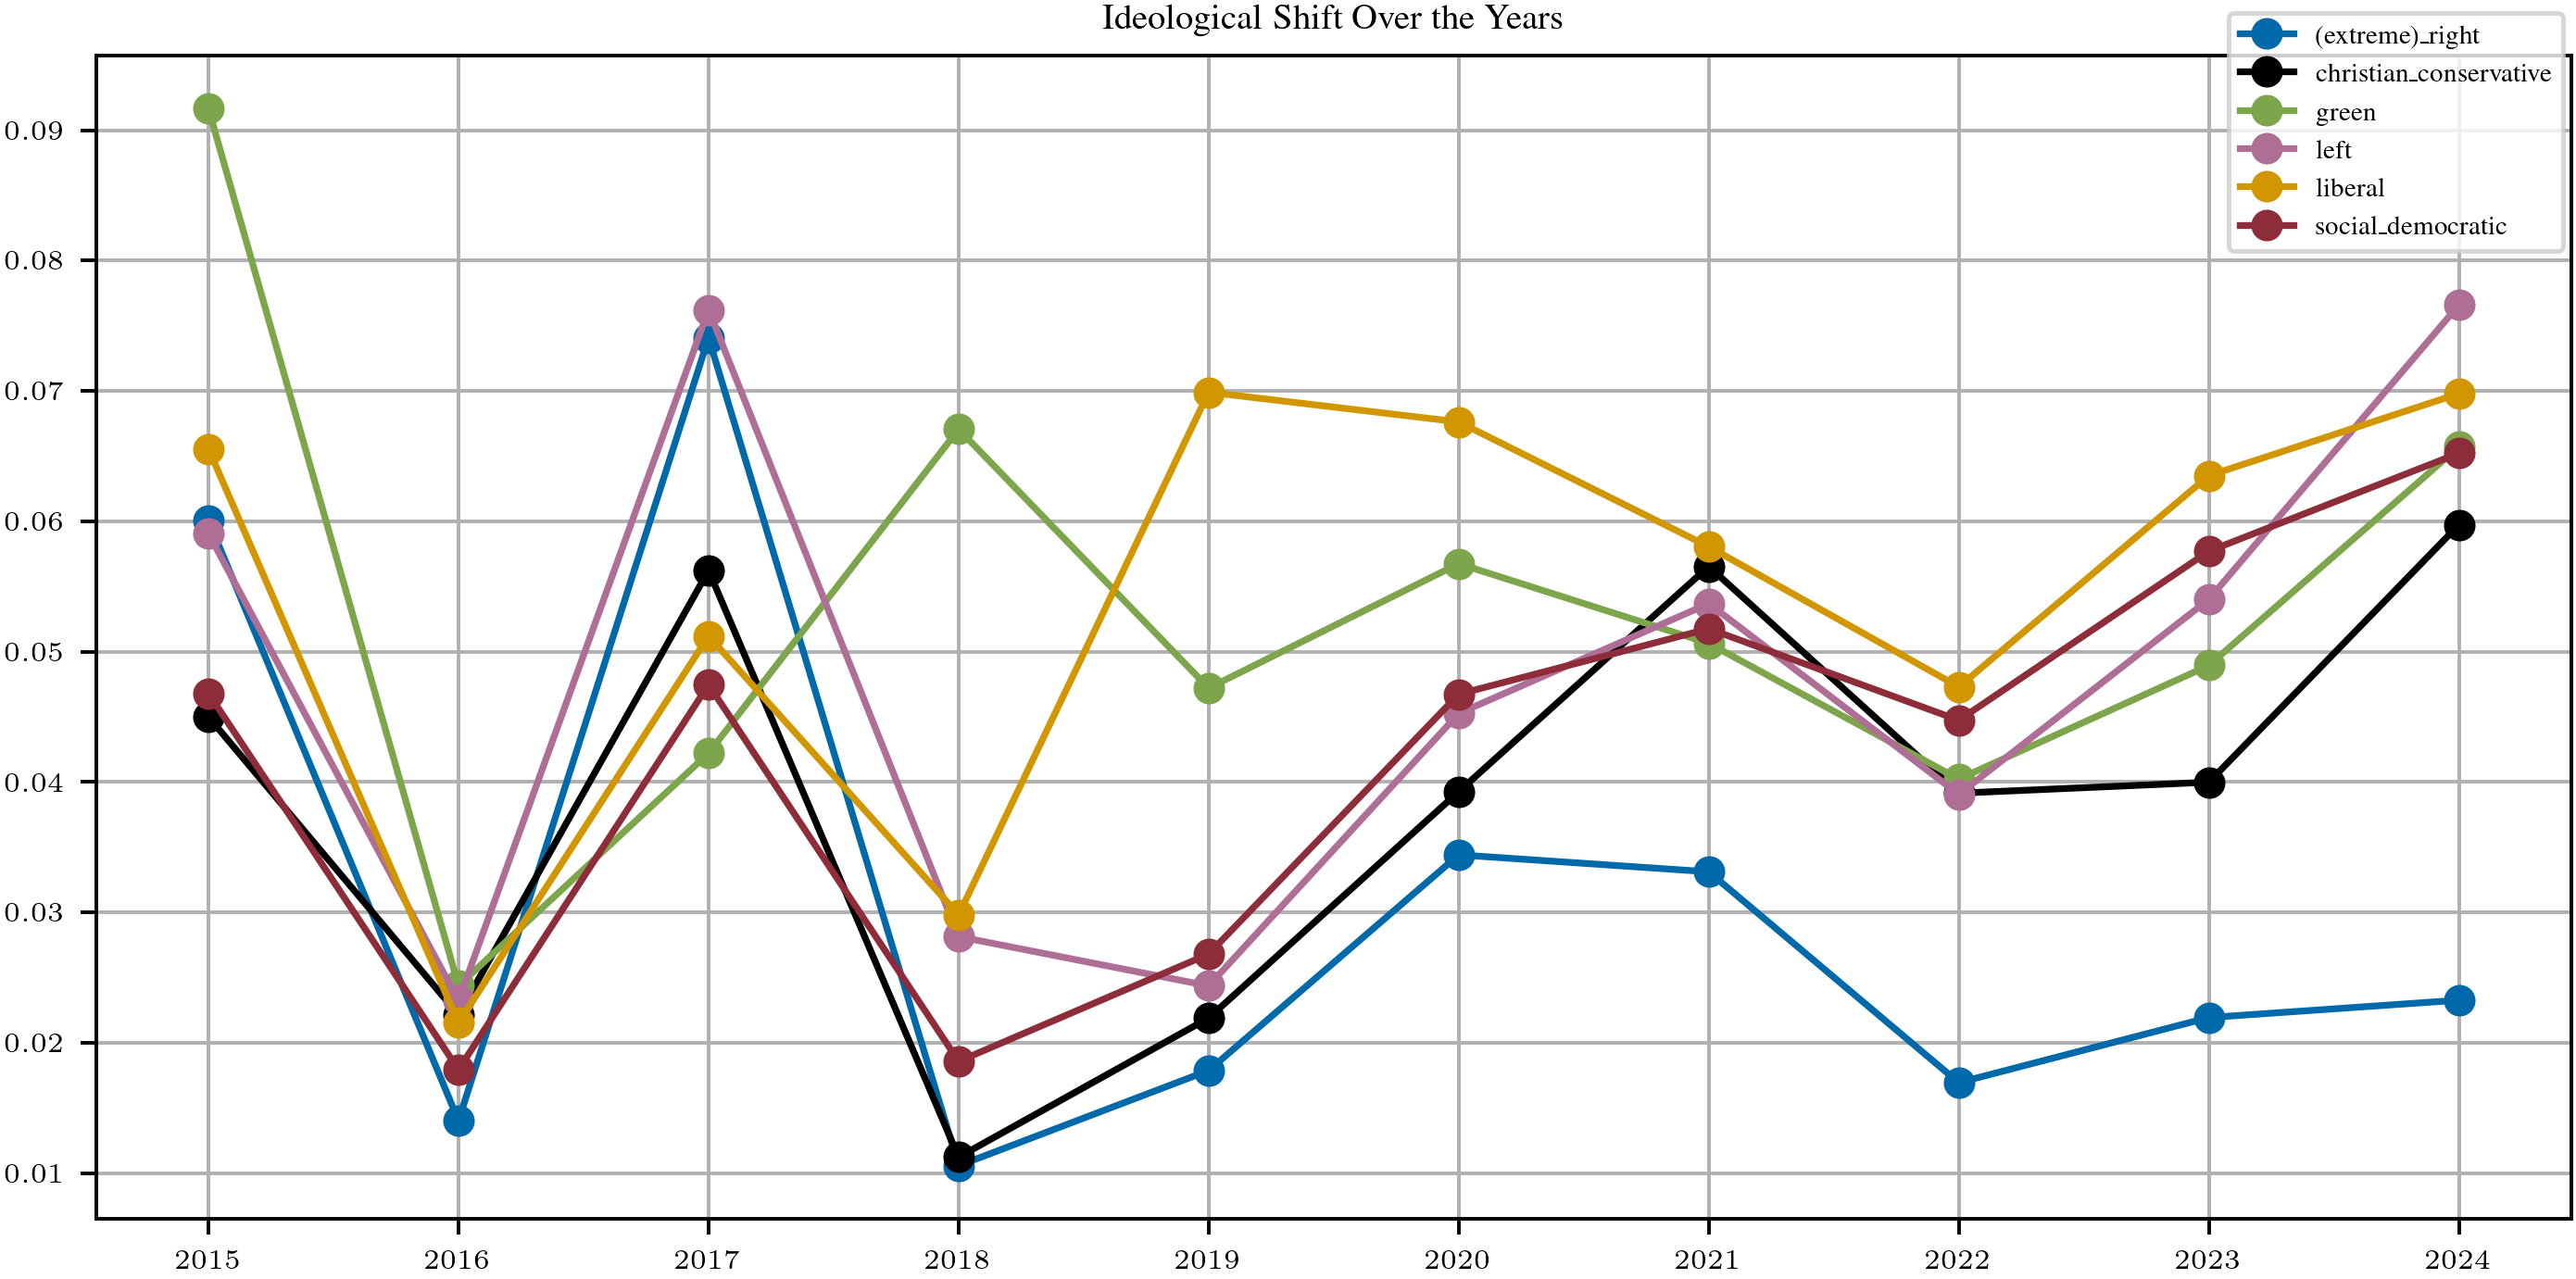

In [ ]:
import matplotlib.ticker as ticker
import torch
from torch.nn.functional import cosine_similarity

fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot()
ax.set_title("Ideological Shift Over the Years")

for party in aggregated[aggregate_on].unique():
    party_mask = aggregated[aggregate_on] == party
    years = aggregated[party_mask]['year']
    party_embeddings = np.stack(aggregated[EMBEDDING_MODEL][party_mask])
    cos_sim = cosine_similarity(torch.from_numpy(party_embeddings[:-1]), torch.from_numpy(party_embeddings[1: ]))
    cos_distance = 1 - cos_sim
    plt.plot(years[1:], cos_distance, marker='o', label=party, color=COLOR_MAPS['block'][party])

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
fig.legend()
ax.grid(which="both")
    


In [50]:
from tqdm import tqdm
from collections import defaultdict
N = df.groupby('block').size().min()  # assume equal size
N_BOOTS = 10_000
results = defaultdict(lambda: list())

for i in tqdm(range(N_BOOTS)):
    sample = df.groupby('block').apply(lambda x: x.sample(N, replace=True), include_groups=False).reset_index()

    aggregated = get_aggregated_embeddings_for_each_year(sample, EMBEDDING_MODEL, "block")
    for party in aggregated[aggregate_on].unique():
        party_mask = aggregated[aggregate_on] == party
        years = aggregated[party_mask]['year']
        party_embeddings = np.stack(aggregated[EMBEDDING_MODEL][party_mask])
        cos_sim = cosine_similarity(torch.from_numpy(party_embeddings[:-1]), torch.from_numpy(party_embeddings[1: ]))
        cos_distance = 1 - cos_sim
        results[party].append(cos_distance)


100%|██████████| 10000/10000 [02:38<00:00, 63.00it/s]


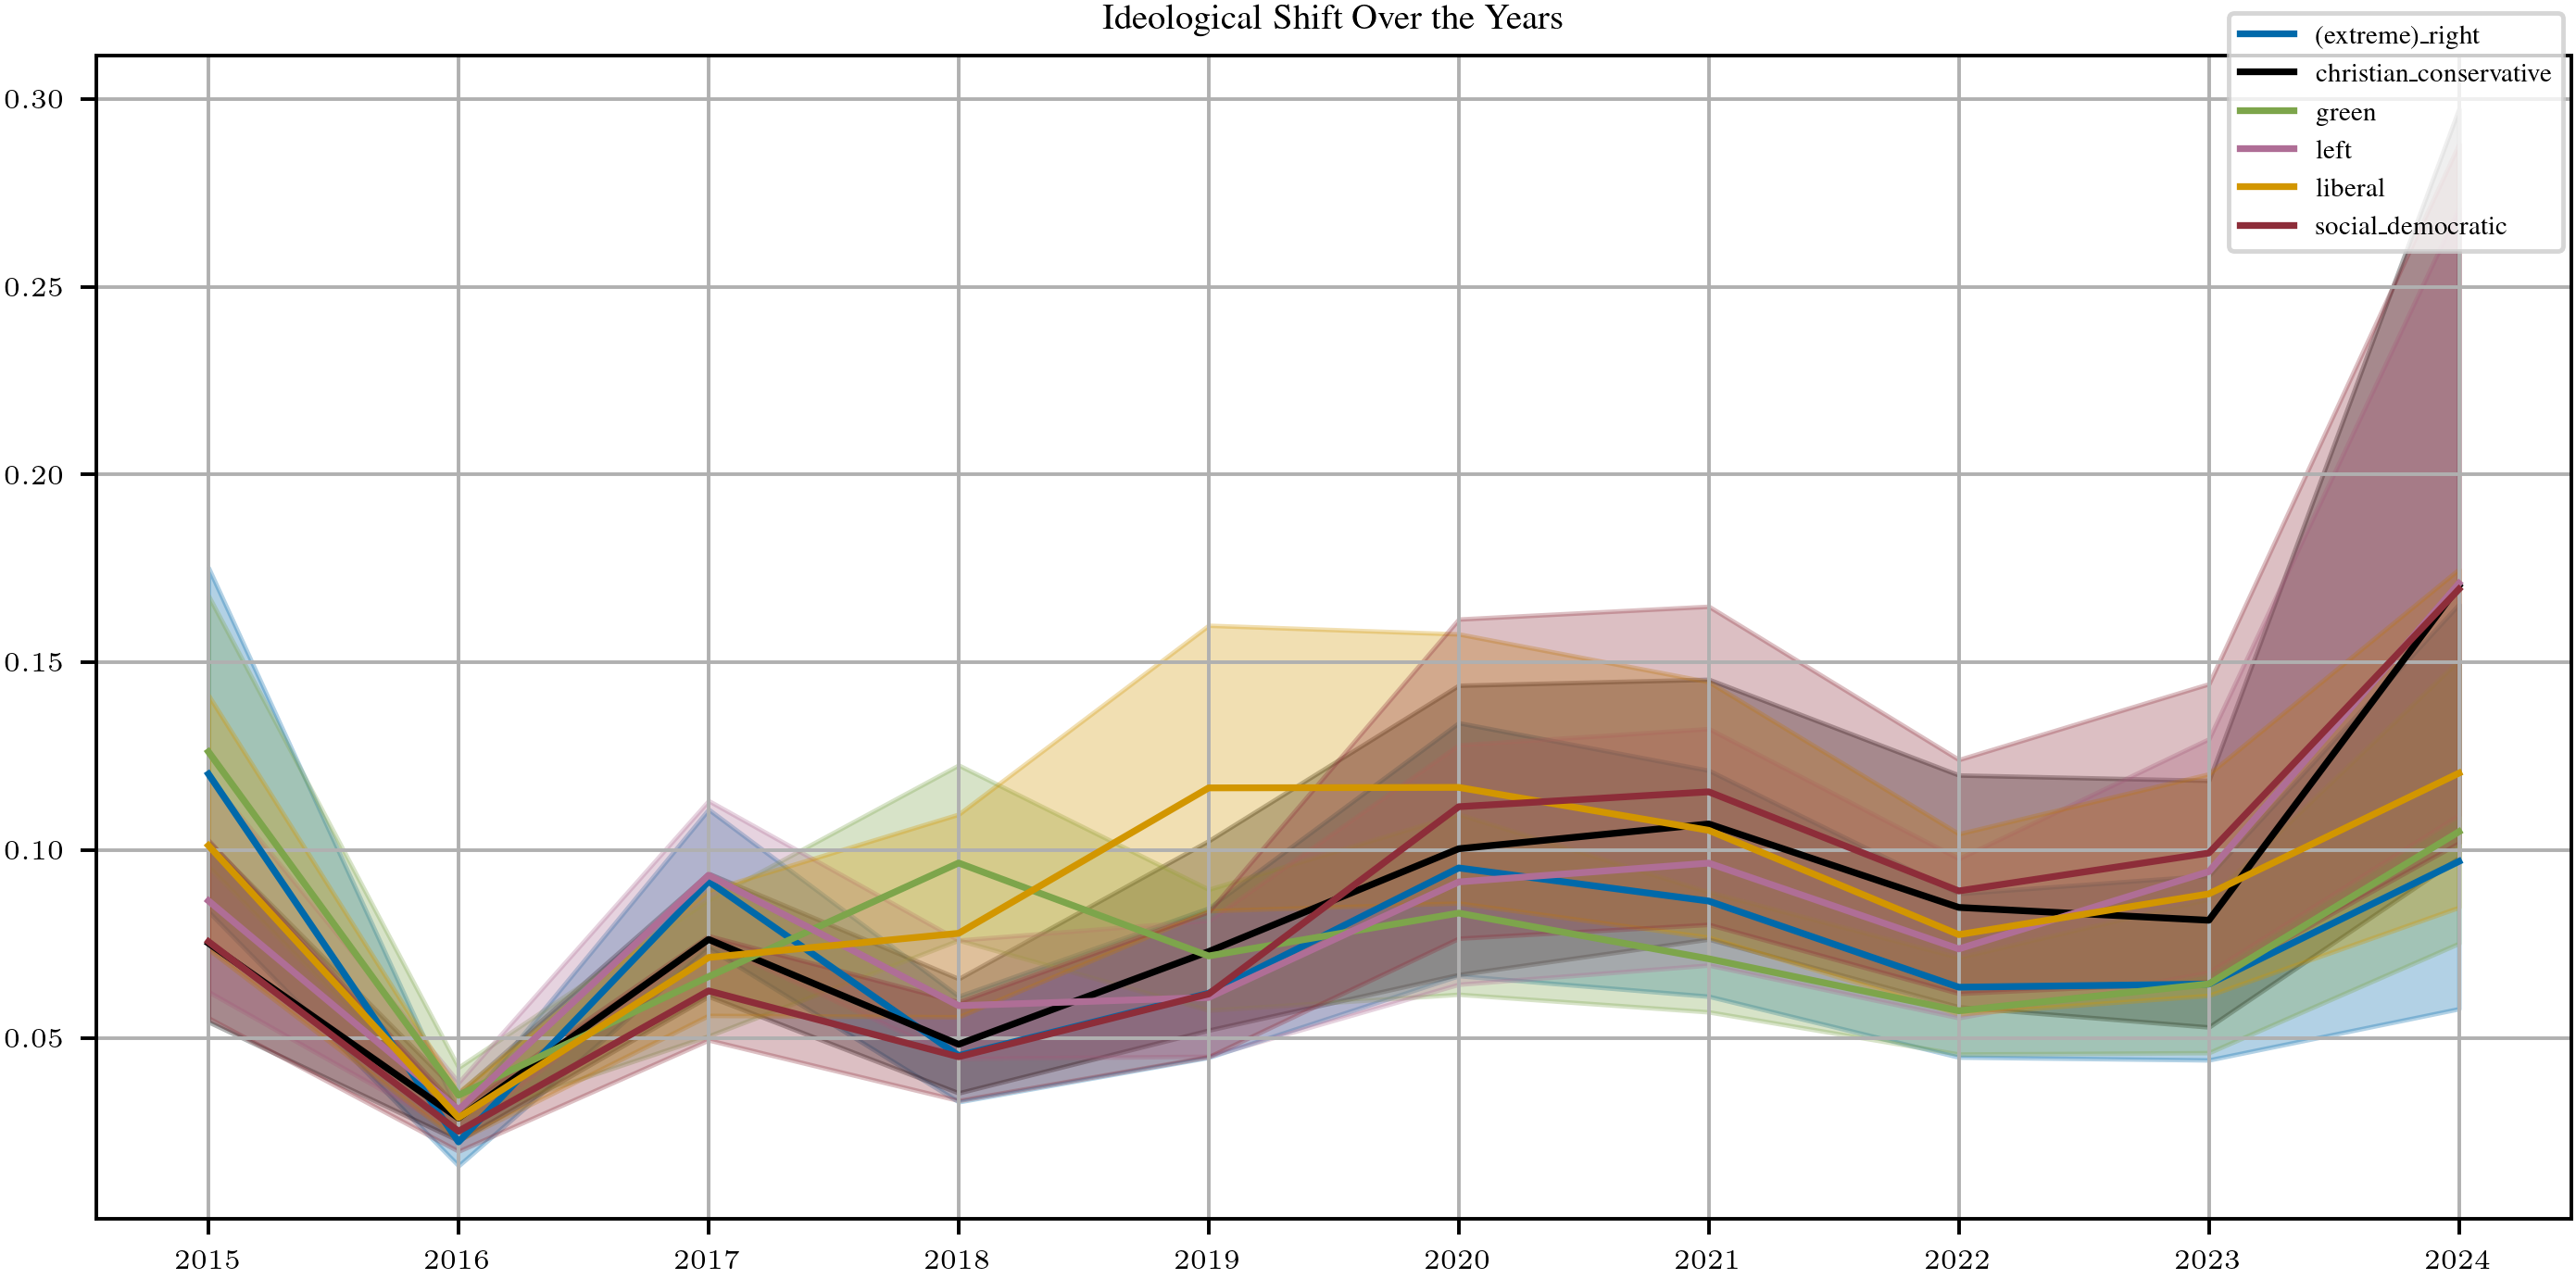

In [51]:
fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot()
ax.set_title("Ideological Shift Over the Years")

aggregated = get_aggregated_embeddings_for_each_year(df, EMBEDDING_MODEL, "block")

for party in aggregated[aggregate_on].unique():
    party_mask = aggregated[aggregate_on] == party
    years = aggregated[party_mask]['year']
    party_embeddings = np.stack(aggregated[EMBEDDING_MODEL][party_mask])
    boots = np.array([elem for elem in results[party] if len(elem) == len(years[1:])])
    low, high = np.percentile(boots, 5, axis=0), np.percentile(boots, 95, axis=0)
    plt.fill_between(years[1:], low, high, alpha=.3, color=COLOR_MAPS['block'][party])
    plt.plot(years[1:], np.mean(boots, axis=0),  label=party, color=COLOR_MAPS['block'][party])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
fig.legend()
ax.grid(which="both")
    

based on the graph, there has been a major ideological jump for most of the parties in 2017. Also exteme right is most consistent with their narratives

In [73]:
def display_ideological_shift(df: pd.DataFrame, aggregated: np.array, aggregated_on: str):
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot()
    ax.set_title("Semantical Shift Over the Years")

    for party in aggregated[aggregated_on].unique():
        party_mask = aggregated[aggregated_on] == party
        years = aggregated[party_mask]['year']
        party_embeddings = np.stack(aggregated[EMBEDDING_MODEL][party_mask])
        cos_sim = cosine_similarity(torch.from_numpy(party_embeddings[:-1]), torch.from_numpy(party_embeddings[1: ]))
        cos_distance = 1 - cos_sim
        plt.plot(years[1:], cos_distance, marker='o',  label=party, color=COLOR_MAPS['block'][party])

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.legend()
    ax.grid(which="both")
    

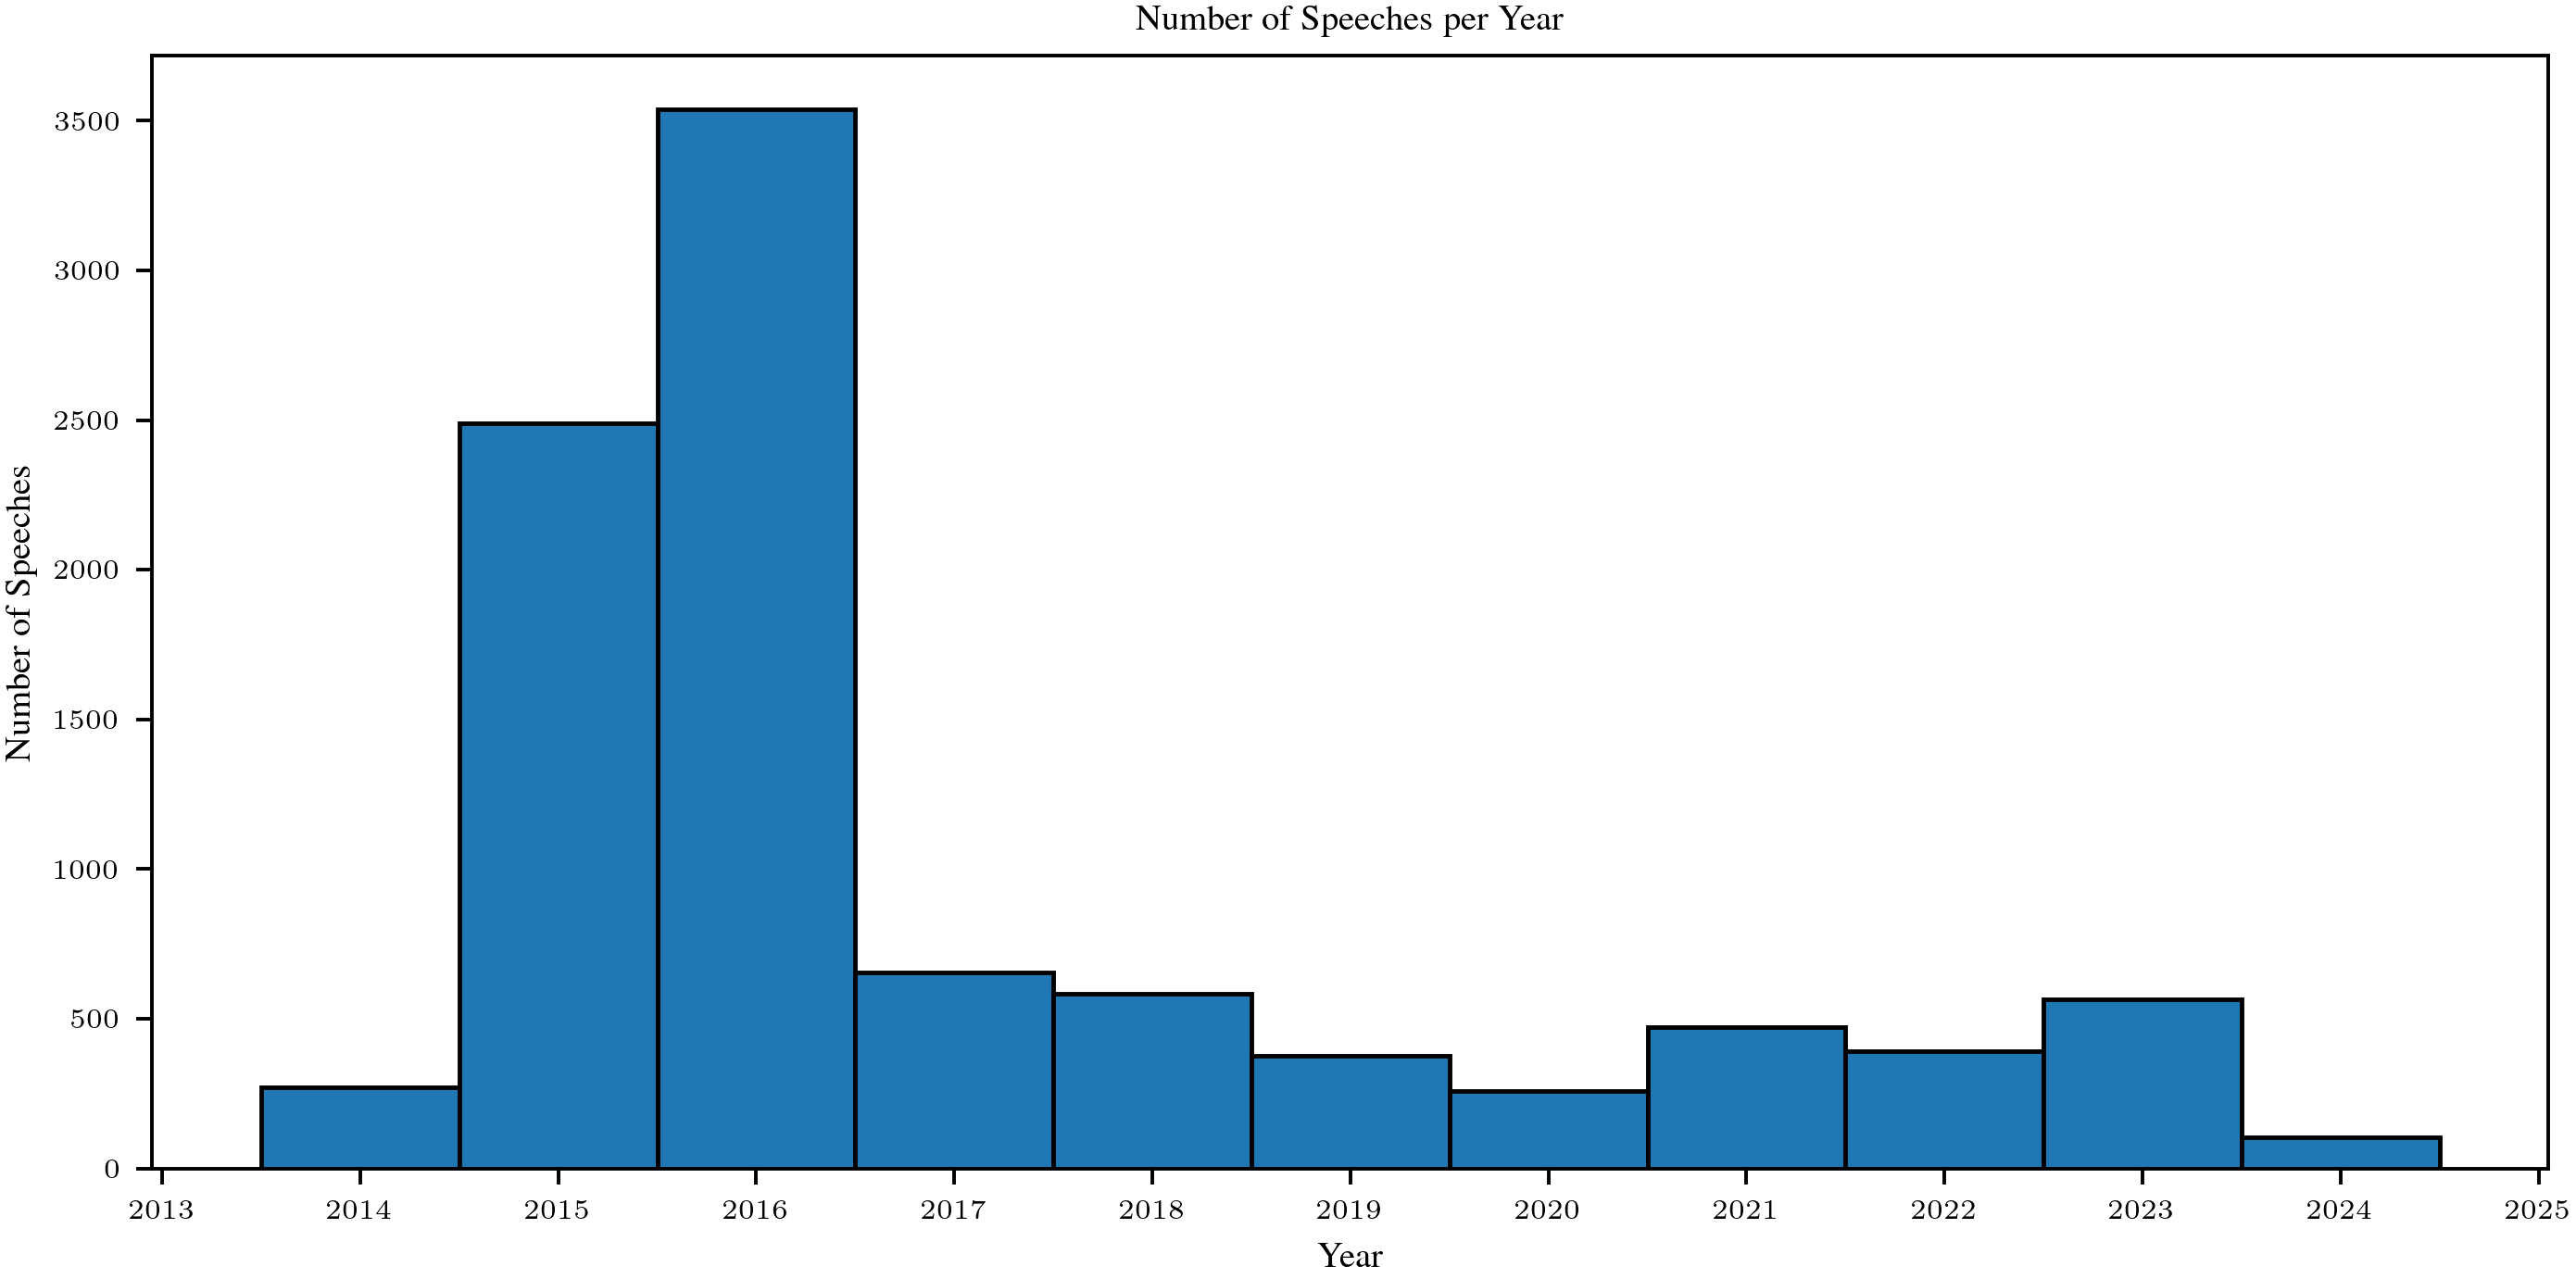

In [53]:
# histogram of dominant topics
fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot()
ax.set_title("Number of Speeches per Year")
ax.hist(pd.to_datetime(df['date']).dt.year.sort_values(), bins=np.arange(2013.5, 2025.5, 1), edgecolor='black')

ax.xaxis.set_label_text('Year')
ax.yaxis.set_label_text('Number of Speeches')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.show()

There is a huge jump in number of speeches between 2016 and 2017, which might be the reason for the jump in the graph above

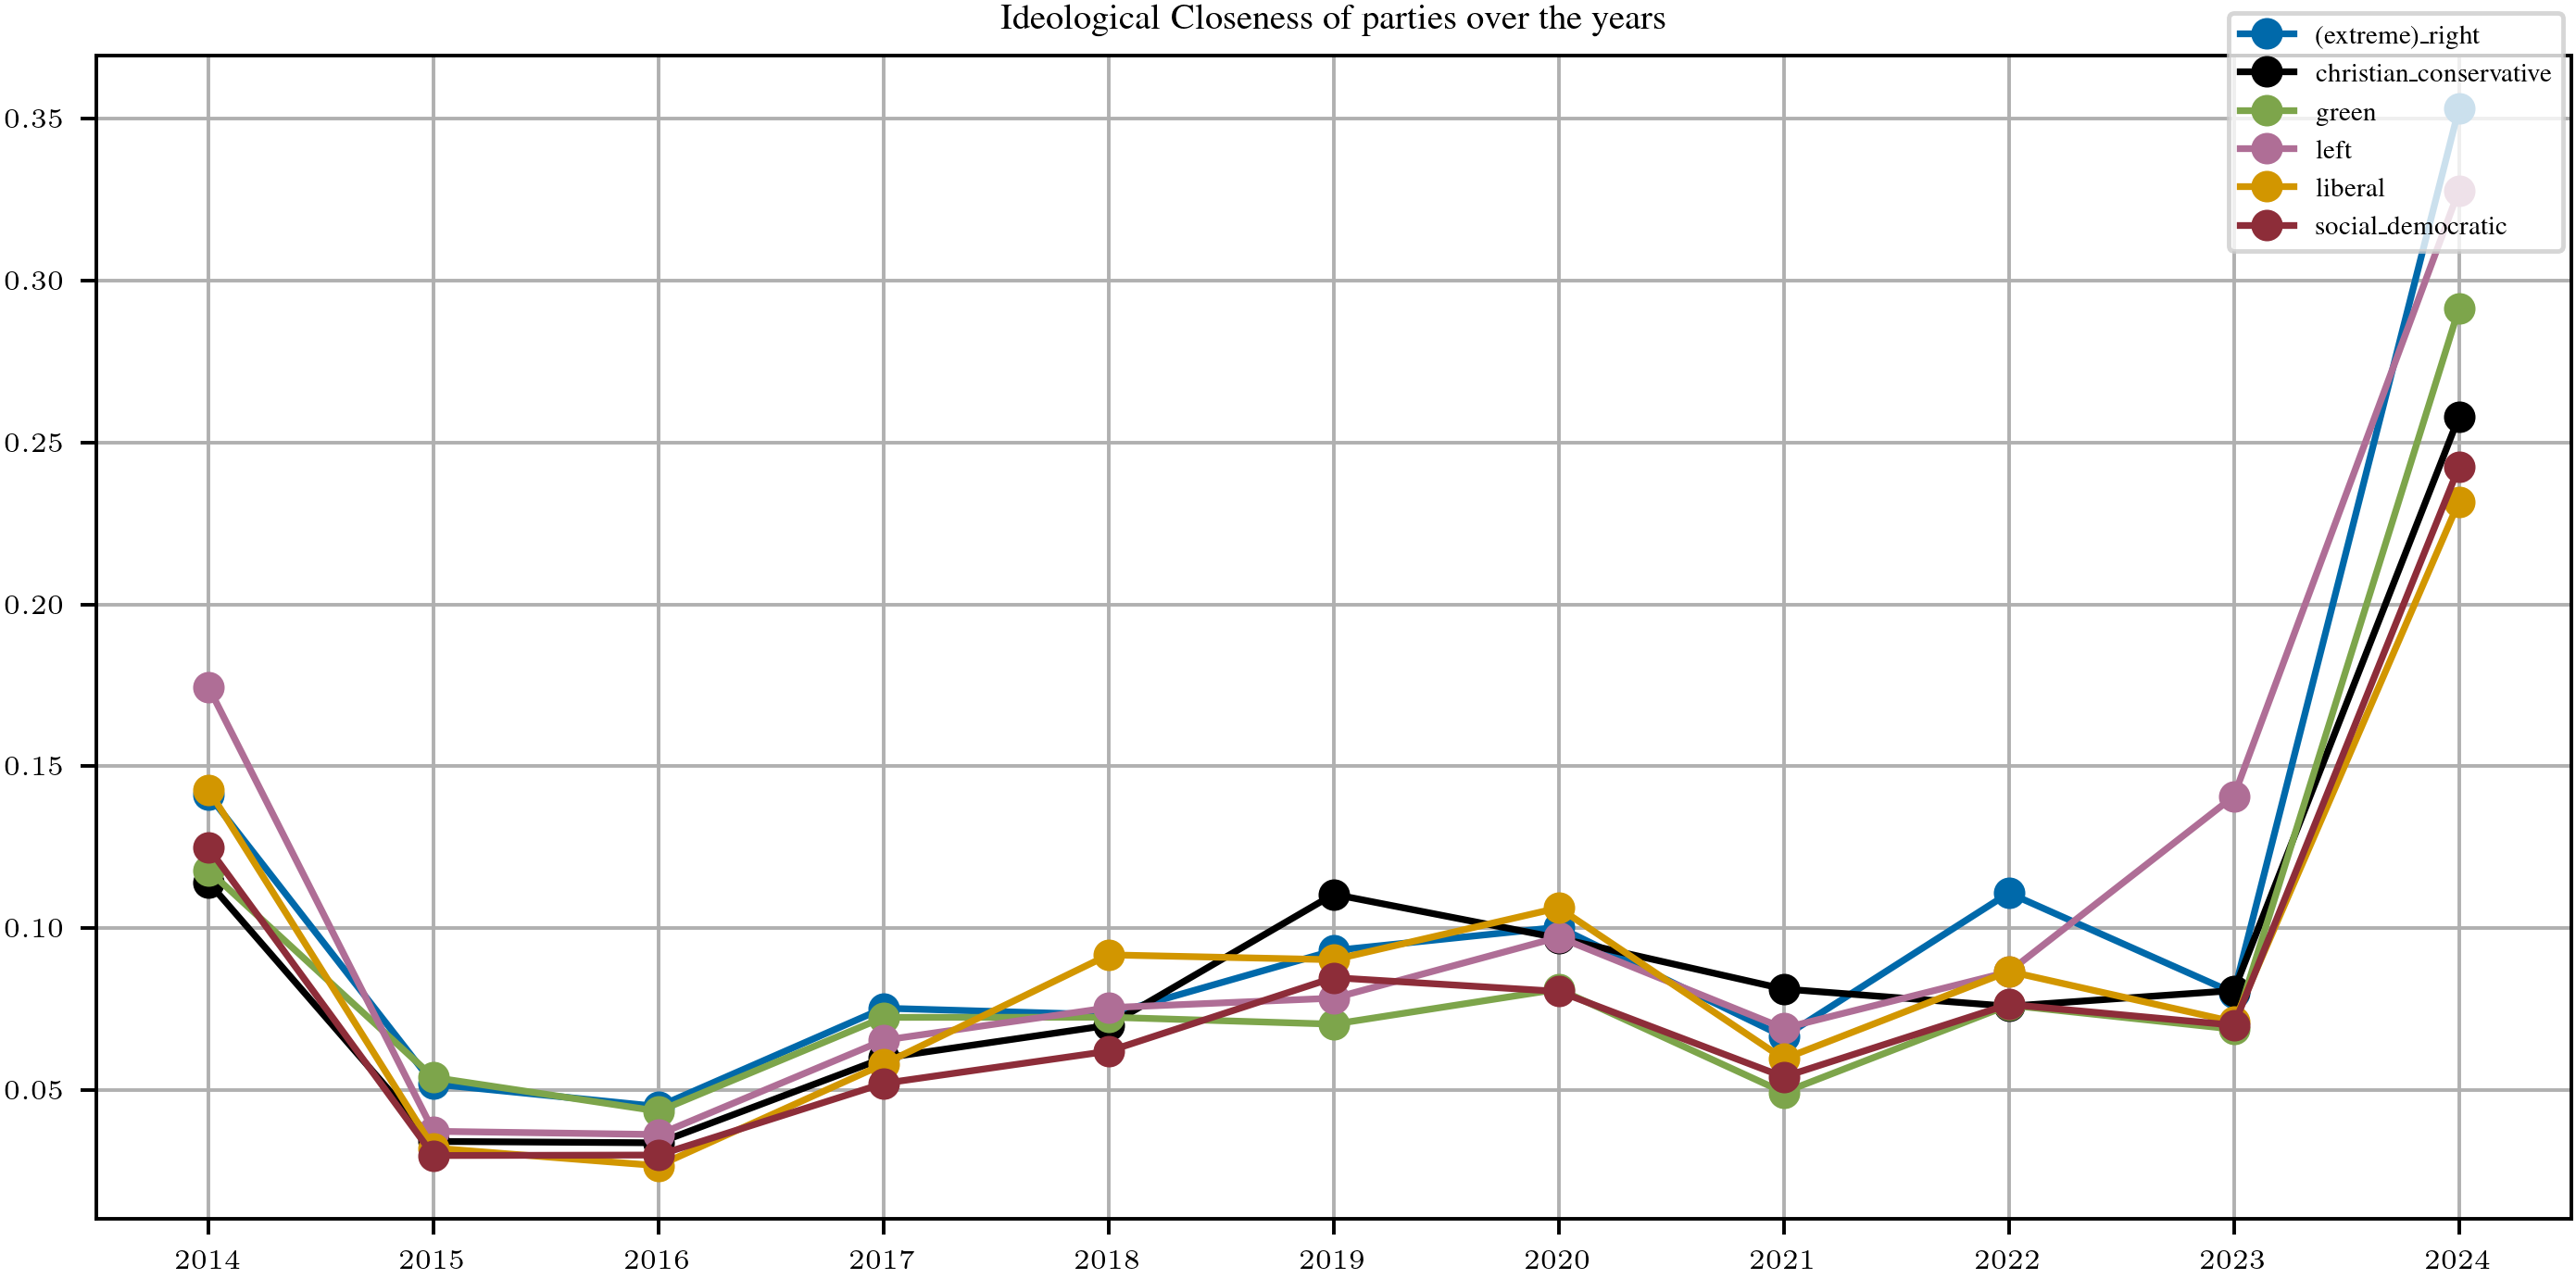

In [61]:

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()
for party in aggregated[aggregate_on].unique():
    party_mask = aggregated[aggregate_on] == party
    years = aggregated[party_mask]['year']
    party_embeddings = np.stack(aggregated[EMBEDDING_MODEL][party_mask])
    other_parties = aggregated[~party_mask]
    cos_distances = []
    for idx, year in enumerate(years):
        curr_party_embedding = party_embeddings[idx]
        other_party_embeddings = np.stack(other_parties[other_parties['year'] == year][EMBEDDING_MODEL])
        cos_sim = cosine_similarity(torch.from_numpy(other_party_embeddings), torch.from_numpy(curr_party_embedding))
        cos_distance = 1 - cos_sim
        cos_distances.append(cos_distance.mean())
    
    plt.plot(years, cos_distances, marker='o',  label=party, color=COLOR_MAPS[aggregate_on][party])
    
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_title("Ideological Closeness of parties over the years")
ax.grid()
fig.legend()
    

semantical closeness of each political block to every other political block

In [ ]:
results = defaultdict(lambda: list())

for i in tqdm(range(N_BOOTS)):
    sample = df.groupby('block').apply(lambda x: x.sample(N, replace=True), include_groups=False).reset_index()

    aggregated = get_aggregated_embeddings_for_each_year(sample, EMBEDDING_MODEL, "block")
    for party in aggregated[aggregate_on].unique():
        party_mask = aggregated[aggregate_on] == party
        years = aggregated[party_mask]['year']
        party_embeddings = np.stack(aggregated[EMBEDDING_MODEL][party_mask])
        other_parties = aggregated[~party_mask]
        cos_distances = []
        for idx, year in enumerate(years):
            curr_party_embedding = party_embeddings[idx]
            other_party_embeddings = np.stack(other_parties[other_parties['year'] == year][EMBEDDING_MODEL])
            cos_sim = cosine_similarity(torch.from_numpy(other_party_embeddings), torch.from_numpy(curr_party_embedding))
            cos_distance = 1 - cos_sim
            cos_distances.append(cos_distance.mean())
        results[party].append(cos_distances)

100%|██████████| 10000/10000 [04:08<00:00, 40.17it/s]


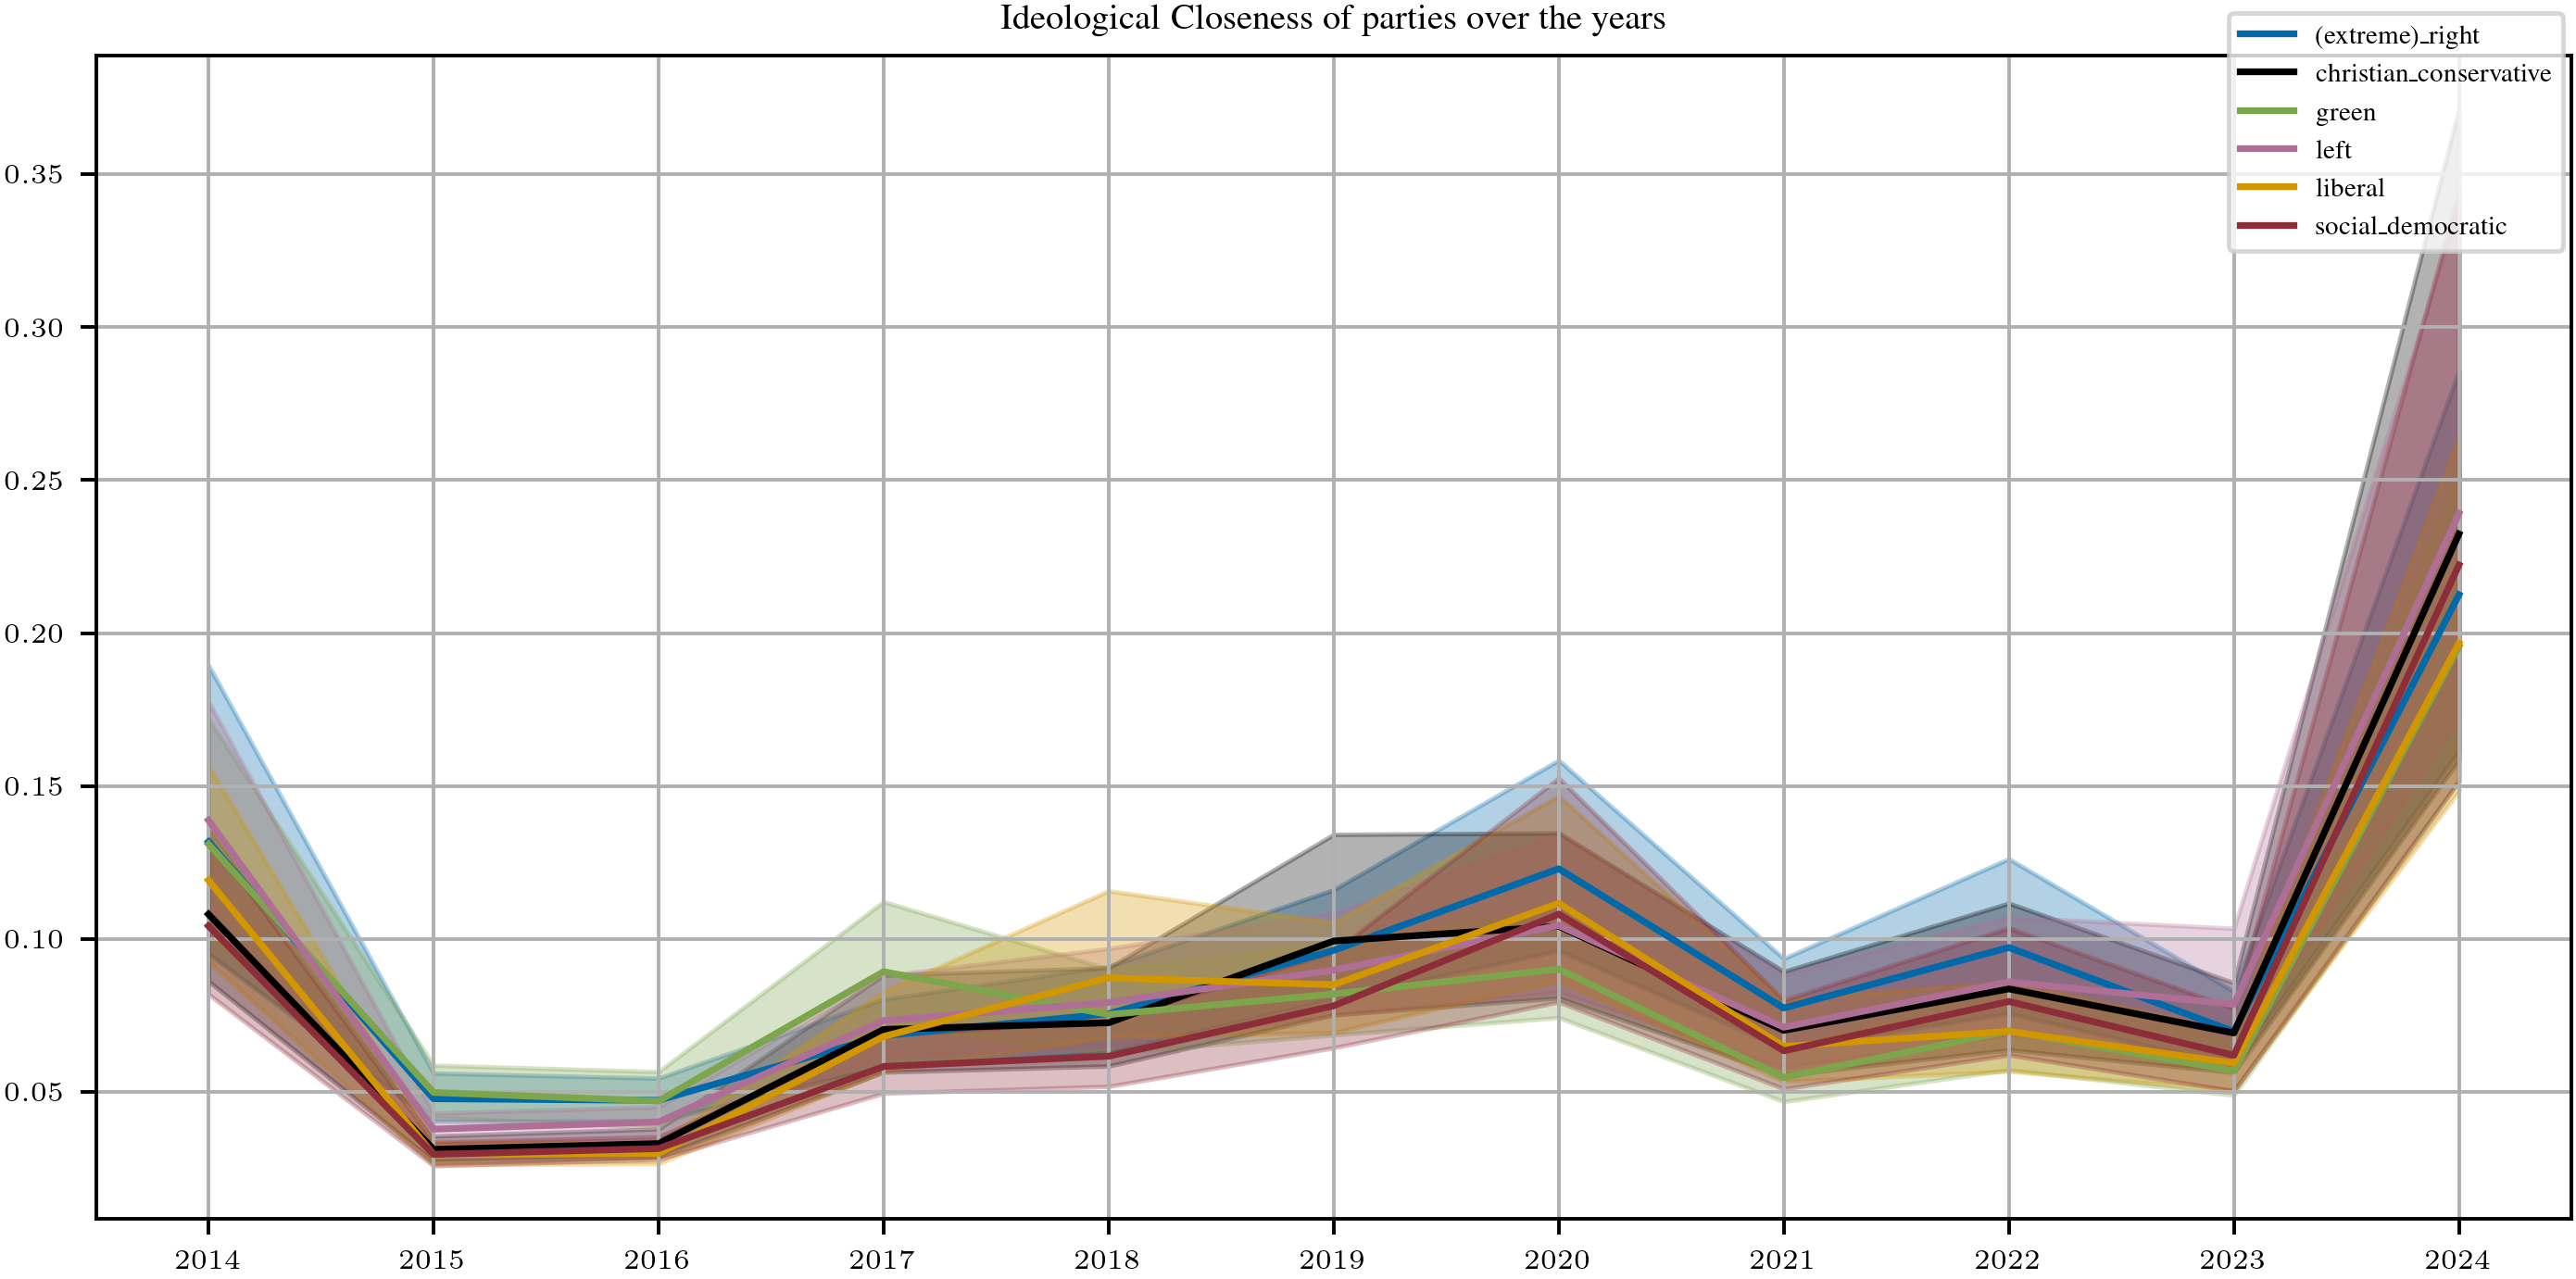

In [ ]:

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()

aggregated = get_aggregated_embeddings_for_each_year(df, EMBEDDING_MODEL, "block")

for party in aggregated[aggregate_on].unique():
    party_mask = aggregated[aggregate_on] == party
    years = aggregated[party_mask]['year']
    party_embeddings = np.stack(aggregated[EMBEDDING_MODEL][party_mask])
    other_parties = aggregated[~party_mask]

    boots = np.array([elem for elem in results[party] if len(elem) == len(years)])
    low, high = np.percentile(boots, 5, axis=0), np.percentile(boots, 95, axis=0)
    plt.fill_between(years, low, high, alpha=.3, color=COLOR_MAPS['block'][party])
    plt.plot(years, np.mean(boots, axis=0),  label=party, color=COLOR_MAPS[aggregate_on][party])
    
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_title("Semantical Closeness of parties over the years")
ax.grid()
fig.legend()
    

In [76]:
def display_ideological_closeness(df: pd.DataFrame, aggregated: np.array, aggregated_on: str):
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot()
    for party in aggregated[aggregated_on].unique():
        party_mask = aggregated[aggregated_on] == party
        years = aggregated[party_mask]['year']
        party_embeddings = np.stack(aggregated[EMBEDDING_MODEL][party_mask])
        other_parties = aggregated[~party_mask]
        cos_distances = []
        for idx, year in enumerate(years):
            curr_party_embedding = party_embeddings[idx]
            other_party_embeddings = np.stack(other_parties[other_parties['year'] == year][EMBEDDING_MODEL])
            cos_sim = cosine_similarity(torch.from_numpy(other_party_embeddings), torch.from_numpy(curr_party_embedding))
            cos_distance = 1 - cos_sim
            cos_distances.append(cos_distance.mean())

        plt.plot(years, cos_distances, marker='o',  label=party, color=COLOR_MAPS[aggregated_on][party])
        
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.set_title("Semantical Closeness of parties over the years")
    ax.grid()
    fig.legend()
        

Over the years social democrats have been the ideological center of european parliament, while at least in the recent years left and right are the most distinct parties 

In [65]:
NUM_BLOCKS = len(aggregated[aggregate_on].unique())
NUM_BLOCKS

6

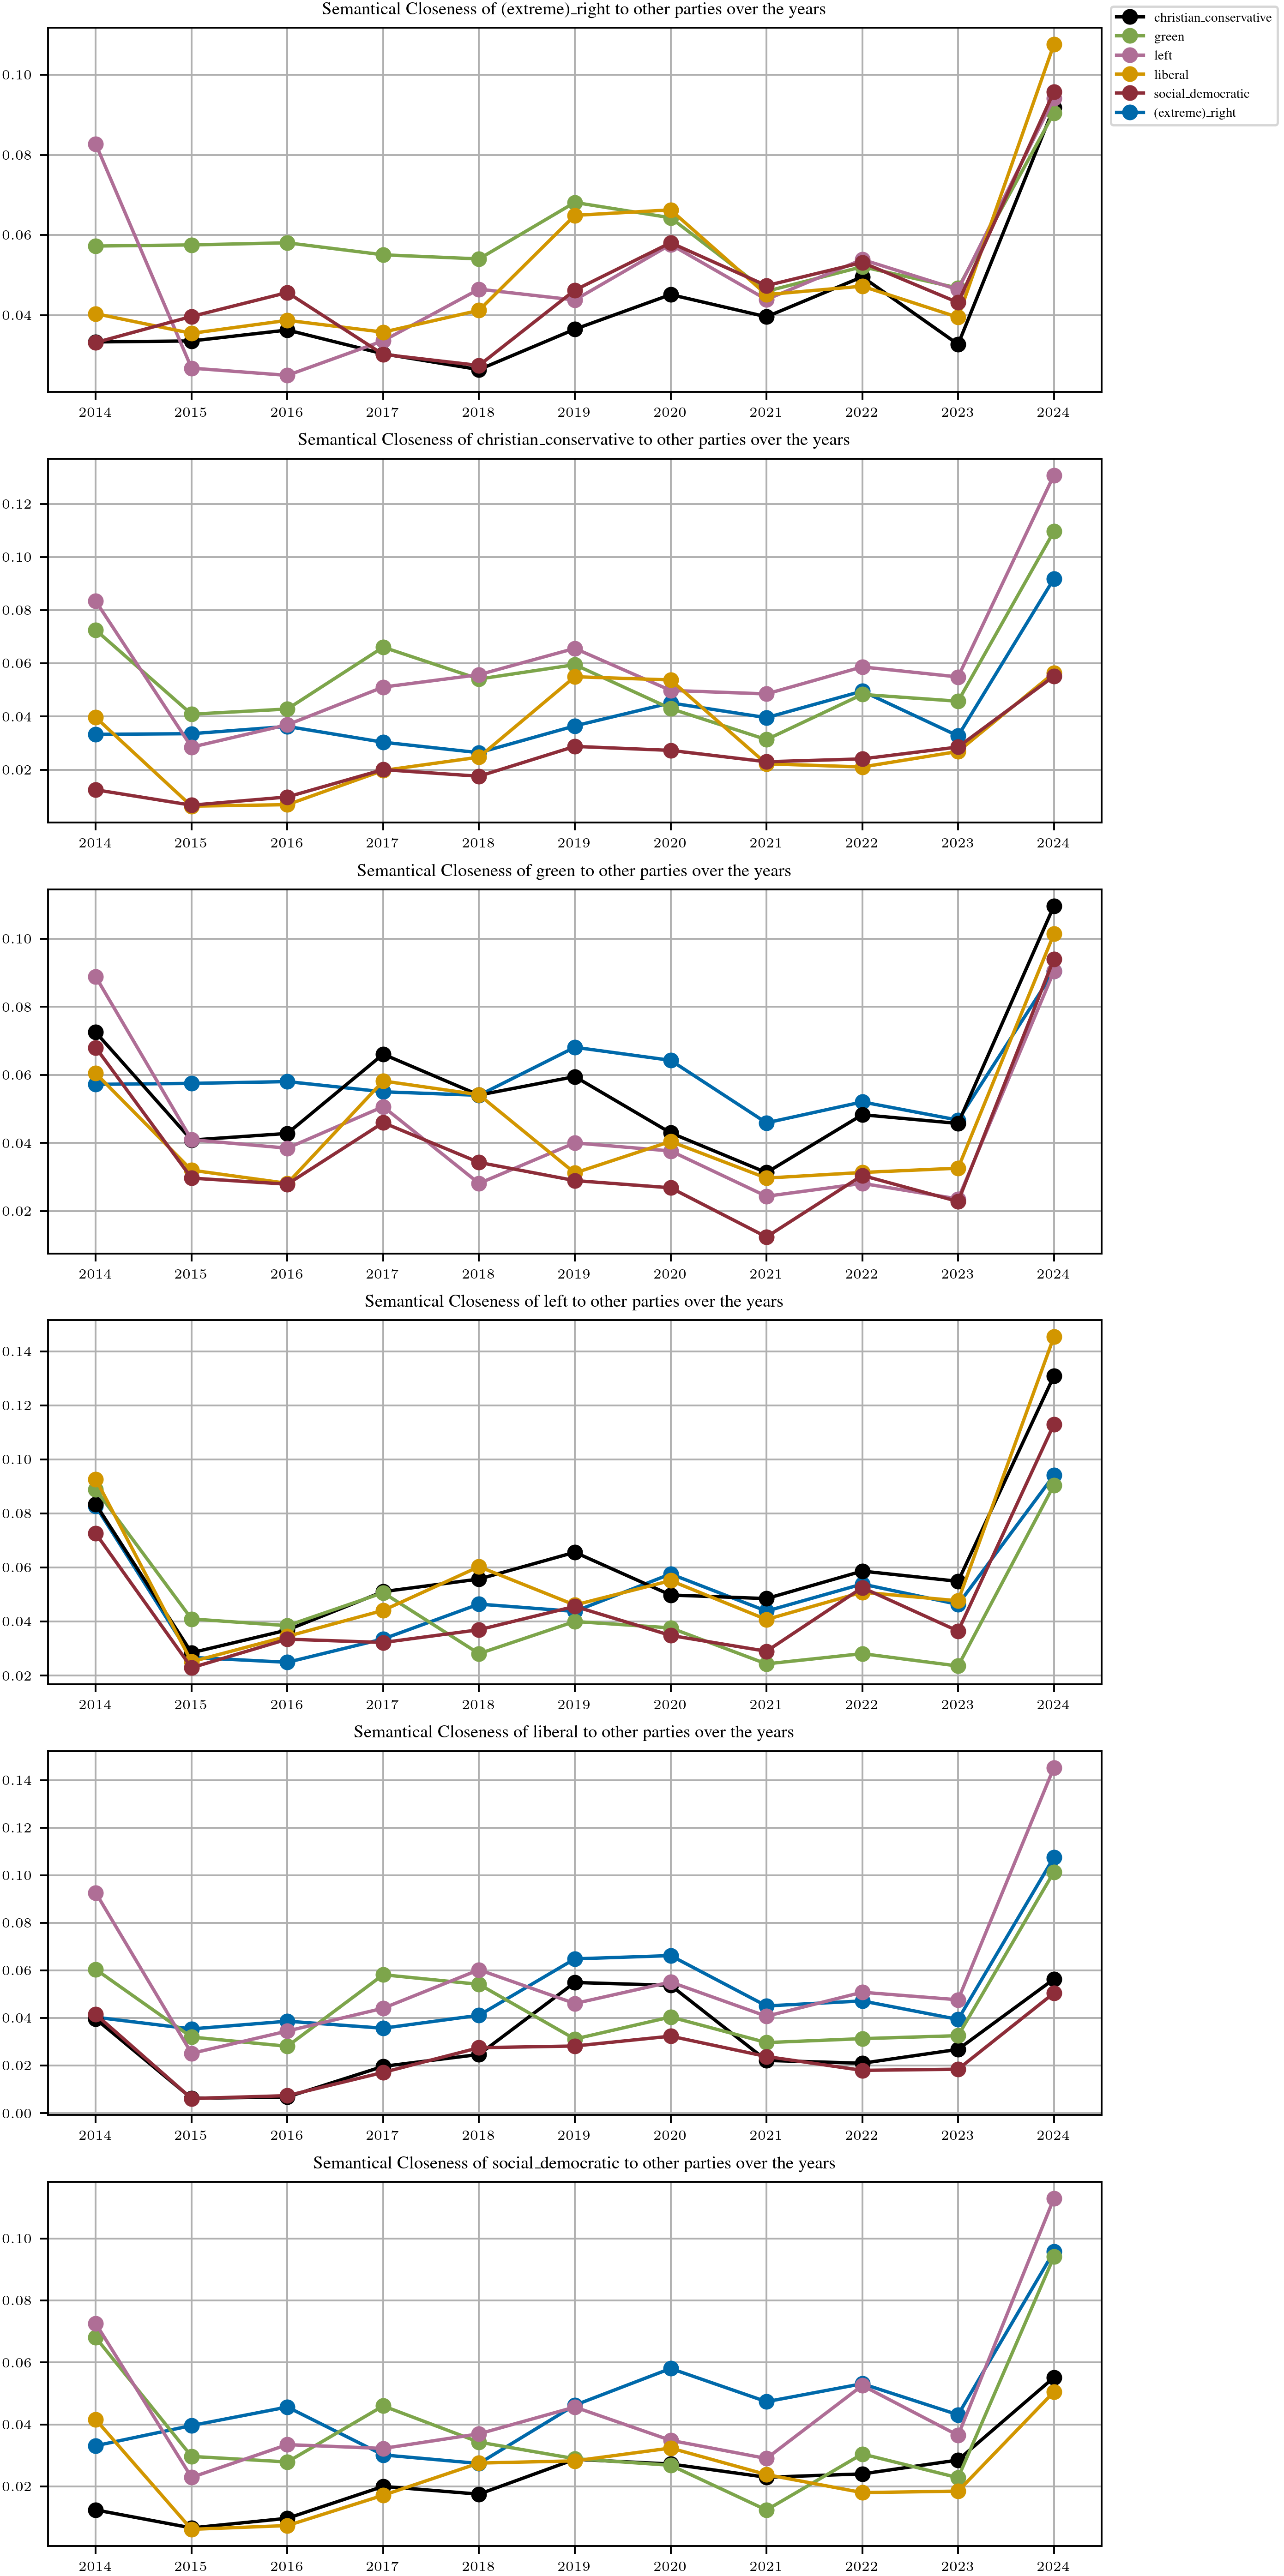

In [67]:

fig = plt.figure(figsize=(8, 16))
axs = fig.subplots(NUM_BLOCKS)

seen_labels = set()


for party_idx, party in enumerate(aggregated[aggregate_on].unique()):
    party_mask = aggregated[aggregate_on] == party
    years = aggregated[party_mask]['year']
    party_embeddings = np.stack(aggregated[EMBEDDING_MODEL][party_mask])
    other_parties = aggregated[~party_mask]
    for other_party_idx in range(NUM_BLOCKS - 1):
        cos_distances = []
        for year_idx, year in enumerate(years):
            curr_party_embedding = party_embeddings[year_idx]
            other_party_embeddings = np.stack(other_parties[other_parties['year'] == year][EMBEDDING_MODEL])[other_party_idx, :]
            cos_sim = cosine_similarity(torch.from_numpy(other_party_embeddings).unsqueeze(0), torch.from_numpy(curr_party_embedding))
            cos_distance = 1 - cos_sim
            cos_distances.append(cos_distance.mean())
        other_party = other_parties[aggregate_on].unique()[other_party_idx]

        label = "_" + other_party if other_party in seen_labels else other_party  # matplotlib doesn't display labels starting with _ this is for avoiding duplicate labels 
        seen_labels.add(other_party)

        axs[party_idx].plot(years, cos_distances, marker='o',  label=label, color=COLOR_MAPS[aggregate_on][other_party])
        
        axs[party_idx].xaxis.set_major_locator(plt.MultipleLocator(1))
        axs[party_idx].set_title(f"Semantical Closeness of {party} to other parties over the years")
        axs[party_idx].grid()
        # axs[party_idx].legend()
fig.legend(loc='outside right upper')
    

## Weighted mean pooling

We might want to avoid skewing our party embeddings with some outlier speeches that have low probability of being on migration according to LDA 

In [68]:
def get_weighted_aggregated_embeddings_for_each_year(df: pd.DataFrame, embedding_column: str, aggregate_on: str):
    yearly_data = df.copy()
    yearly_data['year'] = pd.to_datetime(df['date']).dt.year
    groupped = yearly_data.groupby(by=[aggregate_on, 'year'])
    aggregated_embeddings = groupped[[embedding_column, 'migration_prob']].apply(lambda row: np.stack(row[embedding_column]).T @ np.stack(row['migration_prob']) / sum(row['migration_prob'])).reset_index()
    aggregated_embeddings.columns = [aggregate_on, 'year', embedding_column]
    return aggregated_embeddings


In [69]:
aggregated_on = "block"
aggregated = get_weighted_aggregated_embeddings_for_each_year(df, EMBEDDING_MODEL, aggregated_on)

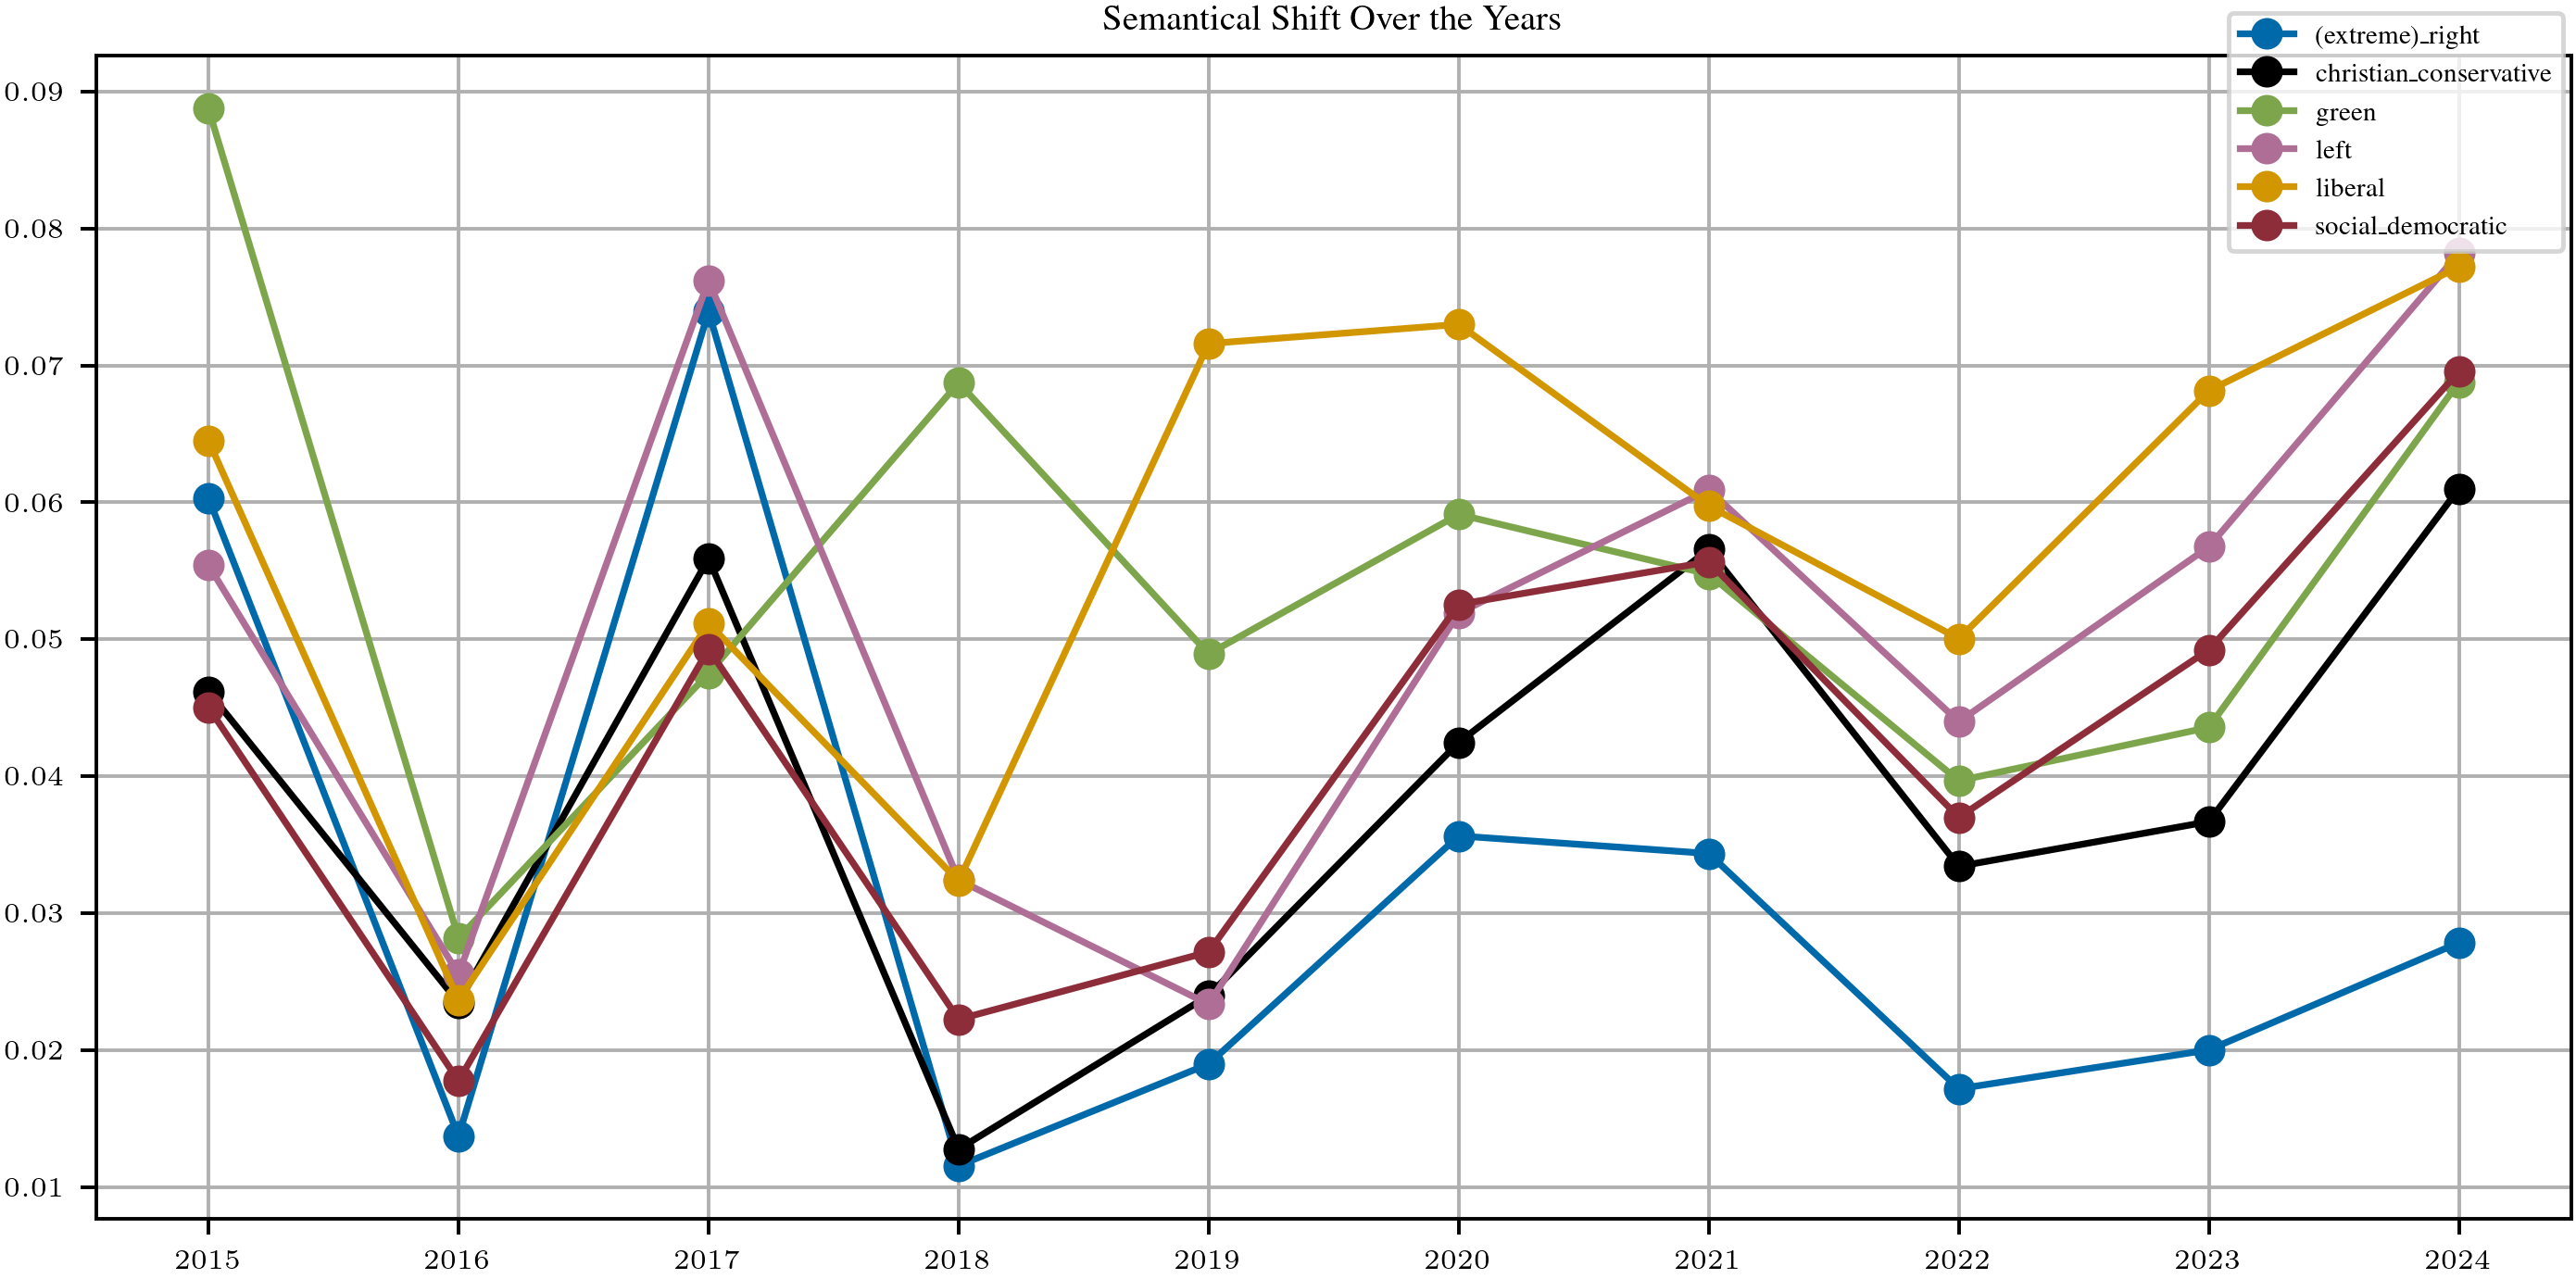

In [74]:
display_ideological_shift(df, aggregated, aggregated_on)

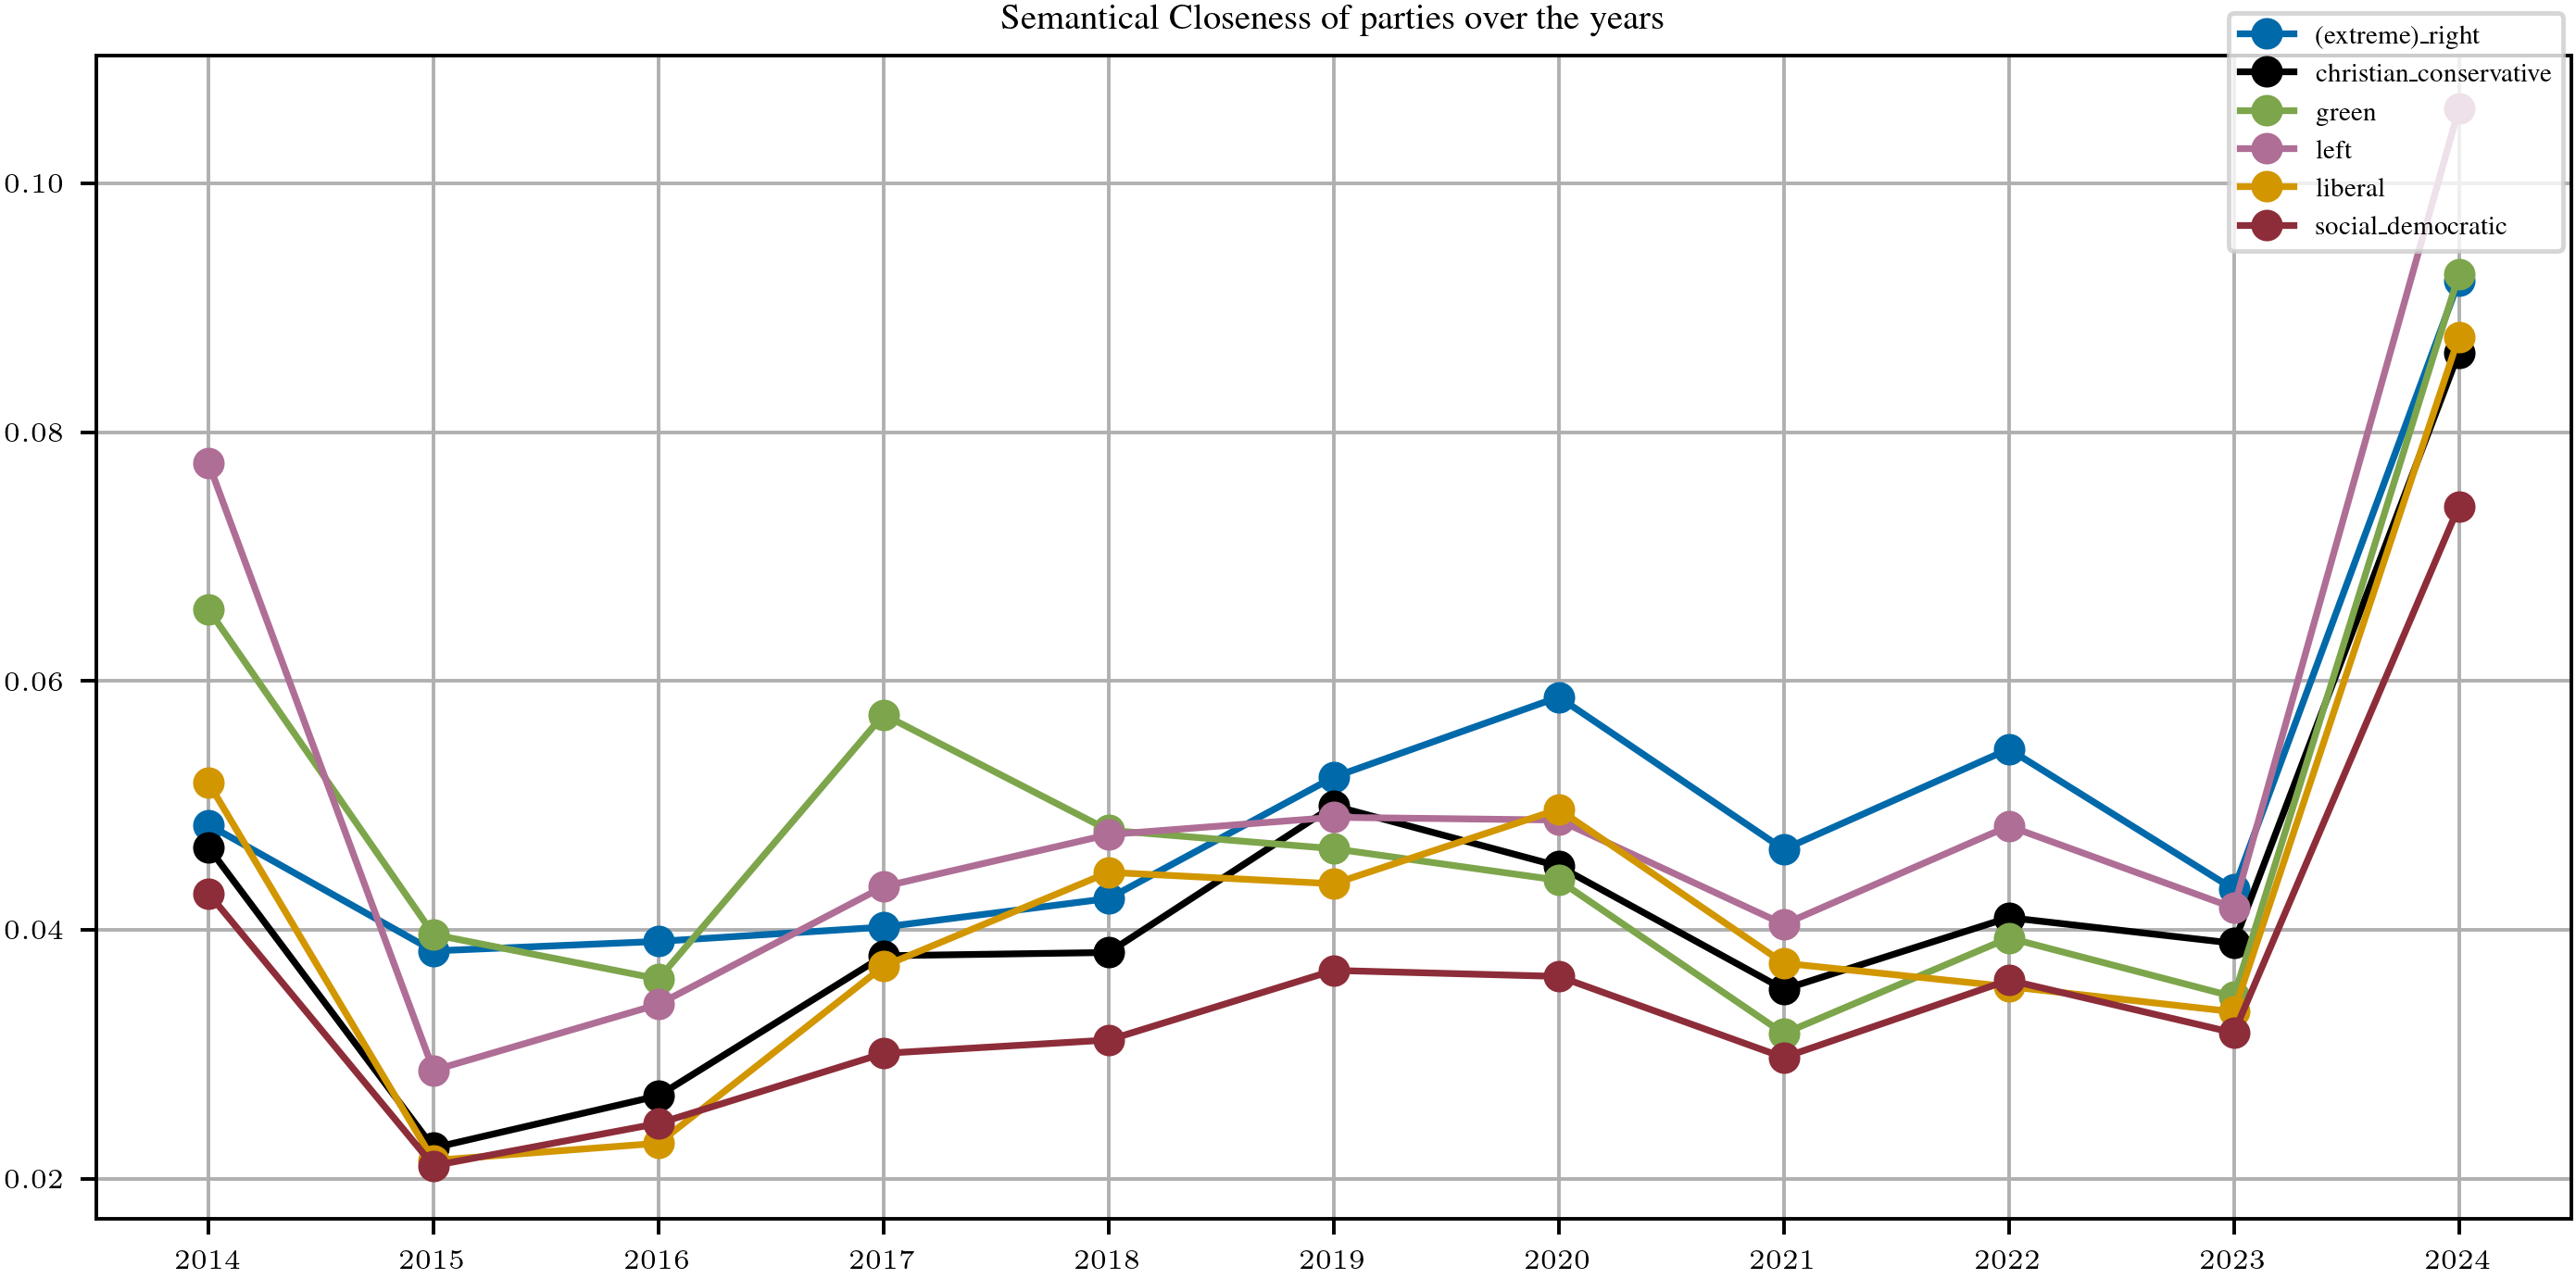

In [77]:
display_ideological_closeness(df, aggregated, aggregated_on)

I don't see much difference between the pooling methods

# PCA + Party Embeddings

In [78]:
from src.dim_reduction import display_axis_semantics, closest_words_for_pc, principle_component_regression

In [79]:
vocab_df = pd.read_parquet(PATH_VOCAB_EMBEDDED)

In [80]:
def plot_aggregated_yearly_data(aggregated: pd.DataFrame, reduced_embeddings: np.array, target_var: str, color_map: dict):
  fig = plt.figure(figsize=(16, 9))
  ax = fig.add_subplot()
  plt.title("Two Dimensional Projection of Political Groups")

  grt = np.abs(reduced_embeddings).max() * 1.1

  ax.set_xlim(-grt, grt)
  ax.set_ylim(-grt, grt)

  scale = grt * 2


  for party in aggregated[target_var].unique():
      party_mask = aggregated[target_var] == party
      years = aggregated[party_mask]['year']
      party_embeddings = reduced_embeddings[party_mask]
      
      plt.scatter(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=color_map[party], label=party)
      for i, year in enumerate(years):
        plt.text(party_embeddings[i,0] - scale * 0.01, party_embeddings[i,1]+ scale * 0.015, f"{year}",
                  fontsize=8, bbox=dict(boxstyle="round", color=color_map[party], alpha=0.7), 
                  color='white',
                  )
  ax.legend()
  return ax

In [81]:
def plot_pca_axis_development(axis: int, aggregated: pd.DataFrame,  target_var: str, reduced_embeddings: np.array, 
                              axis_labels: tuple[list[str]], color_map: dict,
                              top_k: int = 3):

    f = plt.figure(figsize=(10, 5))
    plt.title(f"Development of parties over the years accross reduced-axis {axis}")

    for party in aggregated[target_var].unique():
        party_mask = aggregated[target_var] == party
        years = aggregated[party_mask]['year']
        party_embeddings = reduced_embeddings[party_mask]
        plt.plot(years,  party_embeddings[:, axis], marker='o', color=color_map[party], label=party)


    max_y_lim = max(abs(plt.ylim()[0]), abs(plt.ylim()[1]))

    plt.ylim((-max_y_lim, max_y_lim))  
    plt.axhline(0, linestyle="--")

    ax_label_neg = ', '.join(map(lambda x: x[0], axis_labels[0][:top_k]))
    ax_label_pos = ', '.join(map(lambda x: x[0], axis_labels[1][:top_k]))

    # label for negative axis: 
    plt.figtext(0.87, 0.2, f"[{ax_label_neg}]", horizontalalignment="right")
    # label for positive axis: 
    plt.figtext(0.87, 0.8, f"[{ax_label_pos}]", horizontalalignment="right")
    plt.grid()
    plt.legend(loc="lower left")


In [82]:
def display_results(model, axis: tuple[int], aggregated: pd.DataFrame, vocab_df: pd.DataFrame,
                     reduced_embeddings: np.stack, target_var: str, color_map: dict) -> None:
    axis_labels_0 = closest_words_for_pc(axis[0], model, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
    axis_labels_1  = closest_words_for_pc(axis[1], model, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

    display_axis_semantics([(axis_labels_0), 
                            (axis_labels_1)])

    plot_aggregated_yearly_data(aggregated, reduced_embeddings, target_var, color_map)
    plot_pca_axis_development(0, aggregated, target_var, reduced_embeddings, axis_labels_0, color_map)
    plot_pca_axis_development(1, aggregated, target_var, reduced_embeddings, axis_labels_1, color_map)

In [83]:
*axis, pca = principle_component_regression(df, "block", EMBEDDING_MODEL)

#Classes 6


In [84]:
aggregated_on = "block"
aggregated = get_weighted_aggregated_embeddings_for_each_year(df, EMBEDDING_MODEL, aggregated_on)

In [85]:
reduced_embeddings = pca.transform(np.stack(aggregated[EMBEDDING_MODEL]))[:, axis[0]]

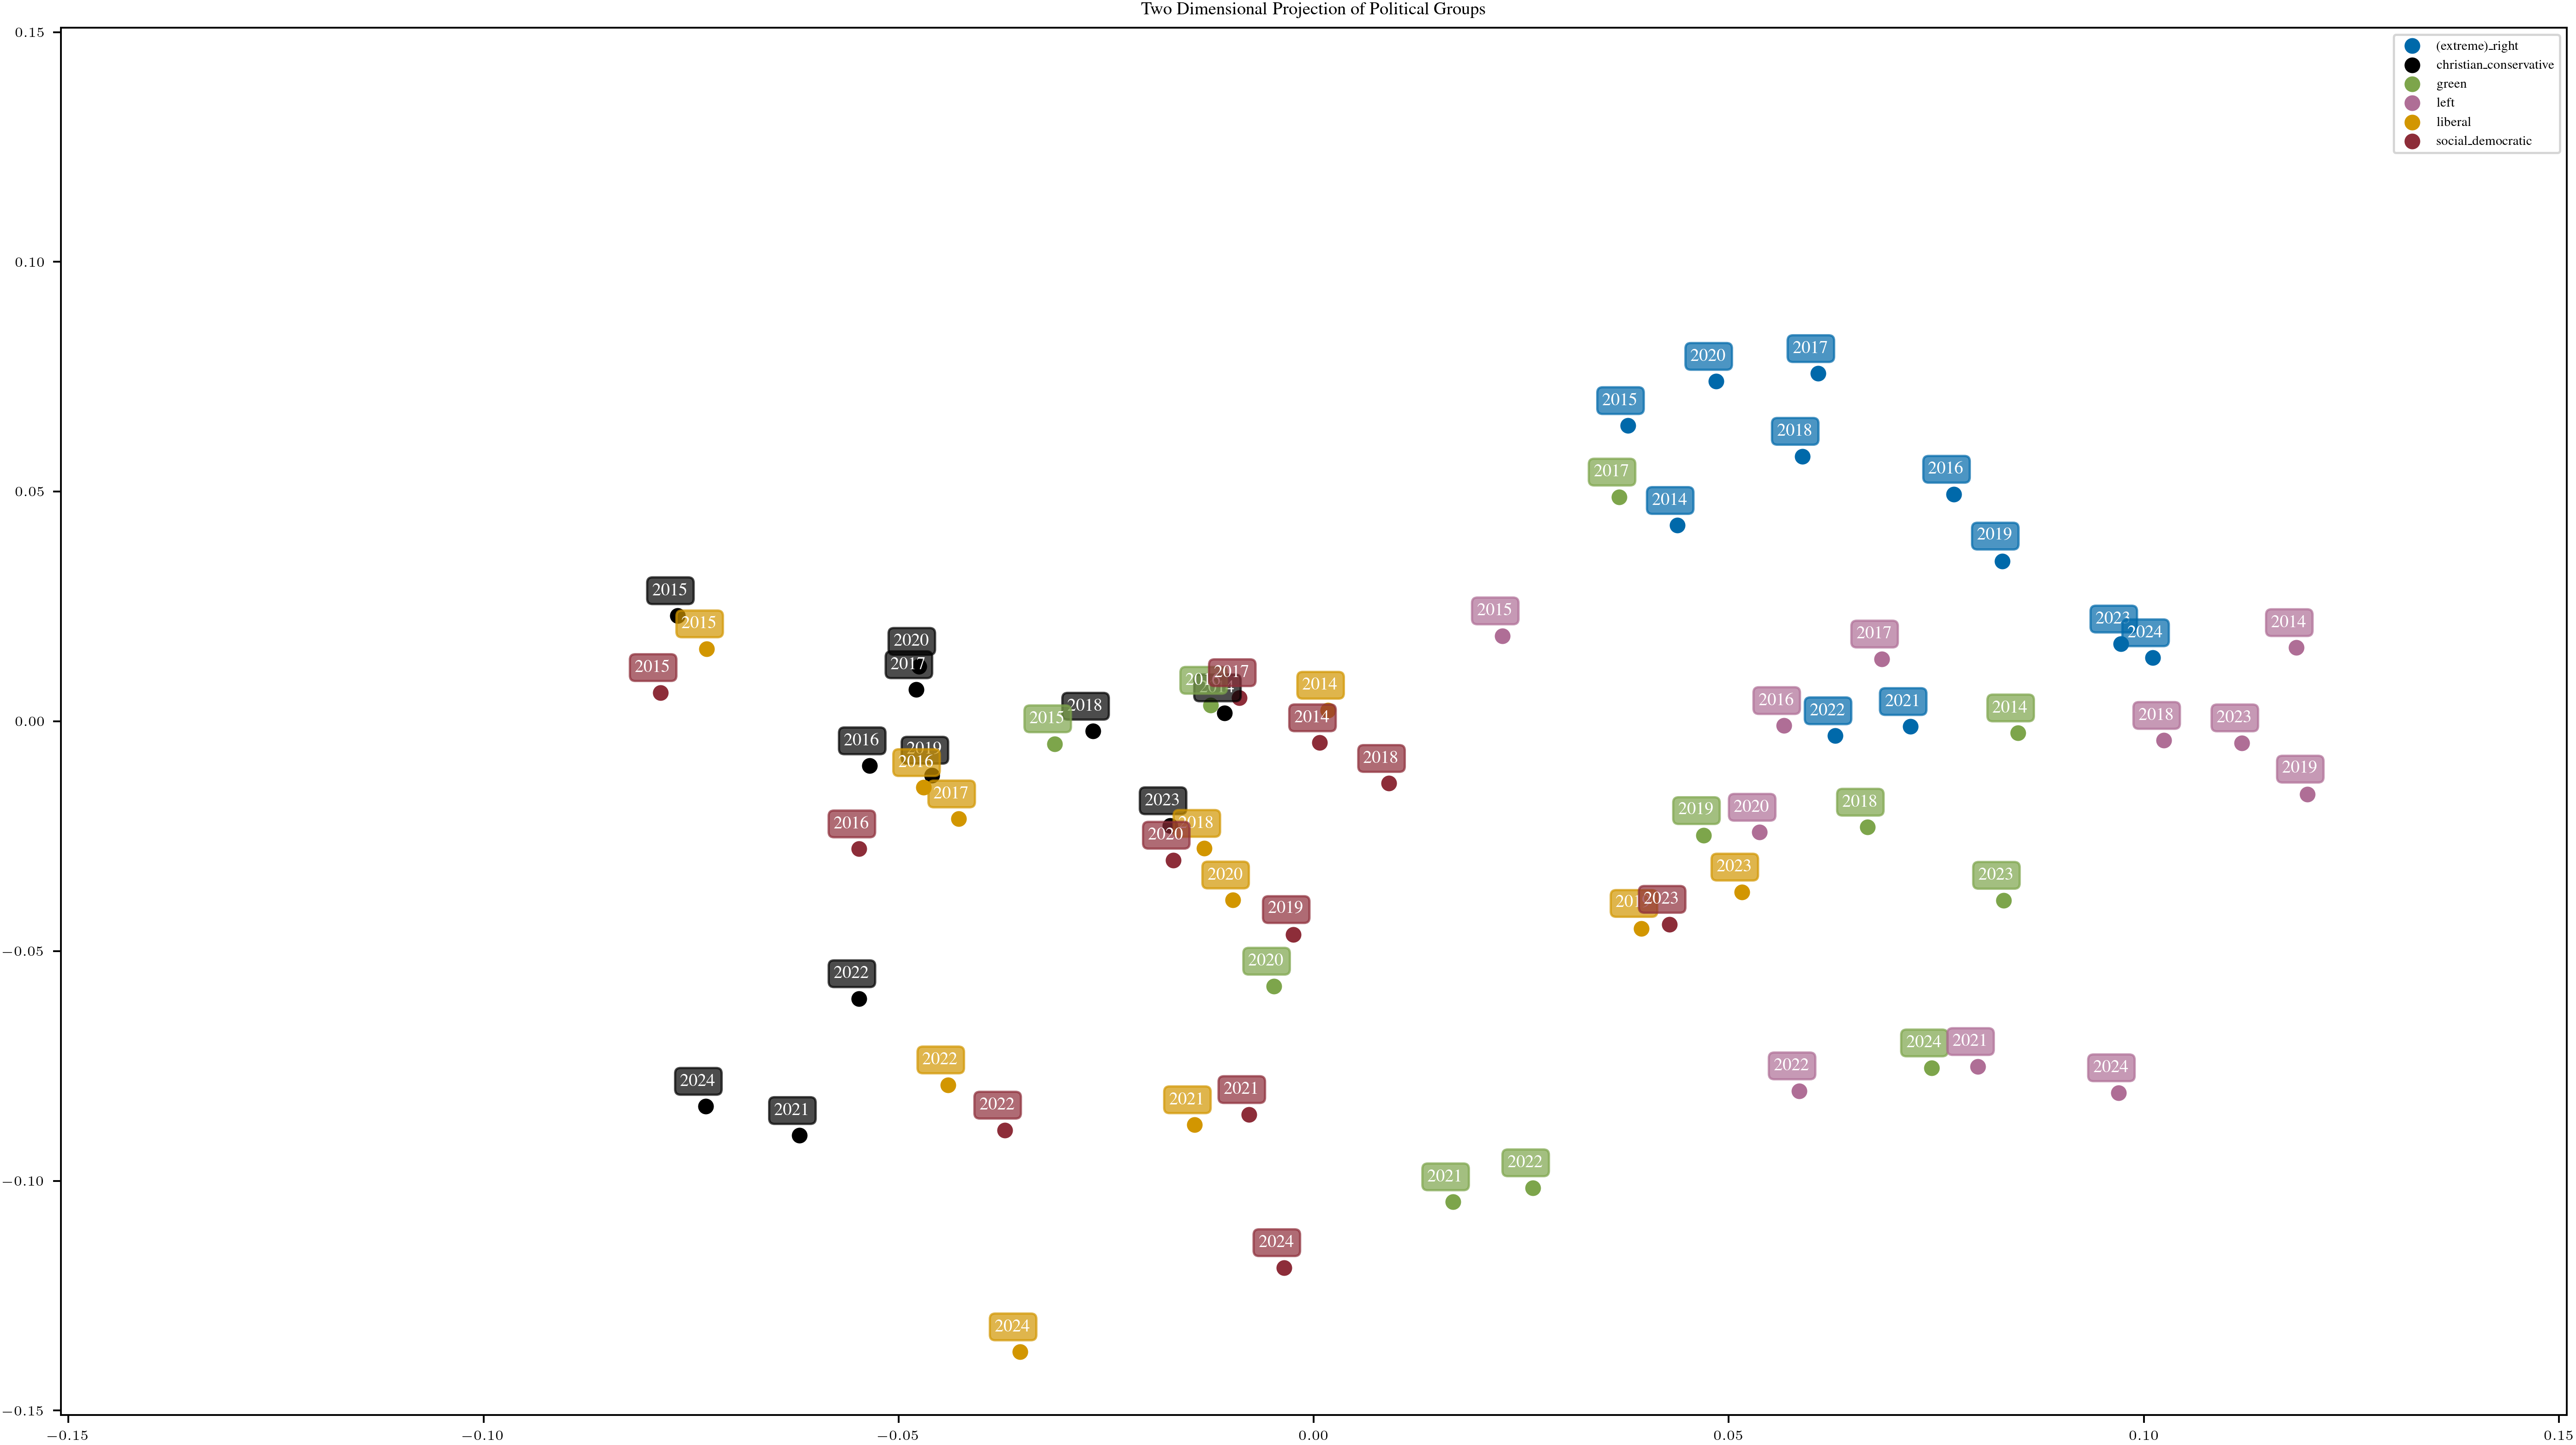

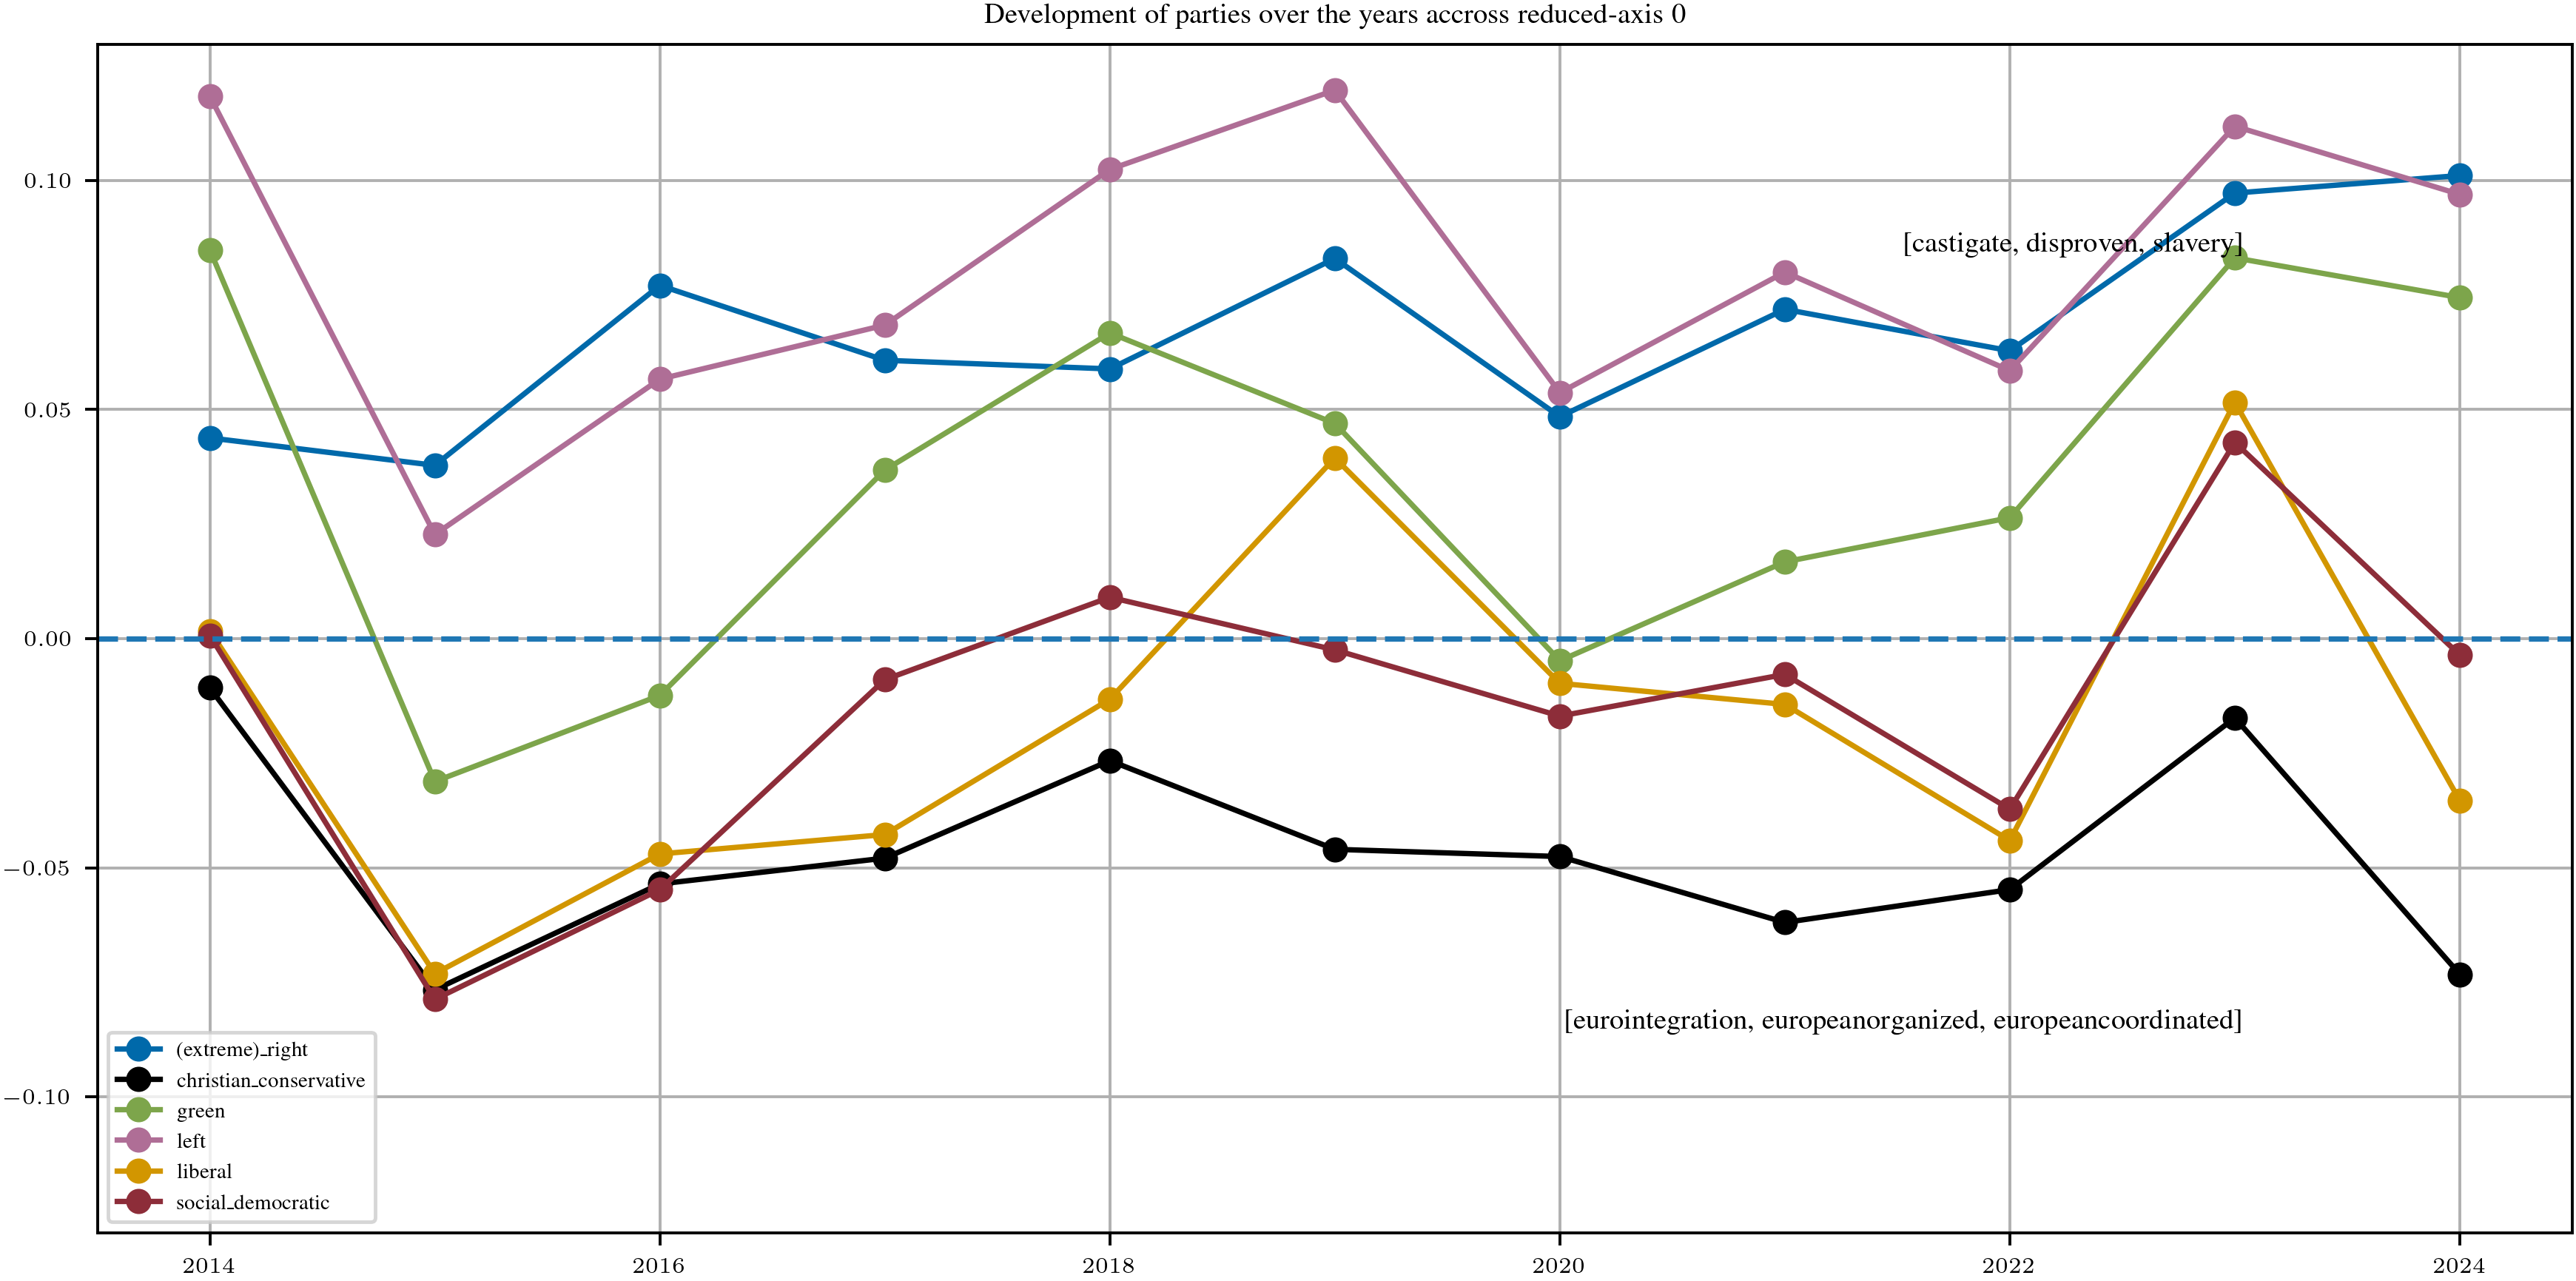

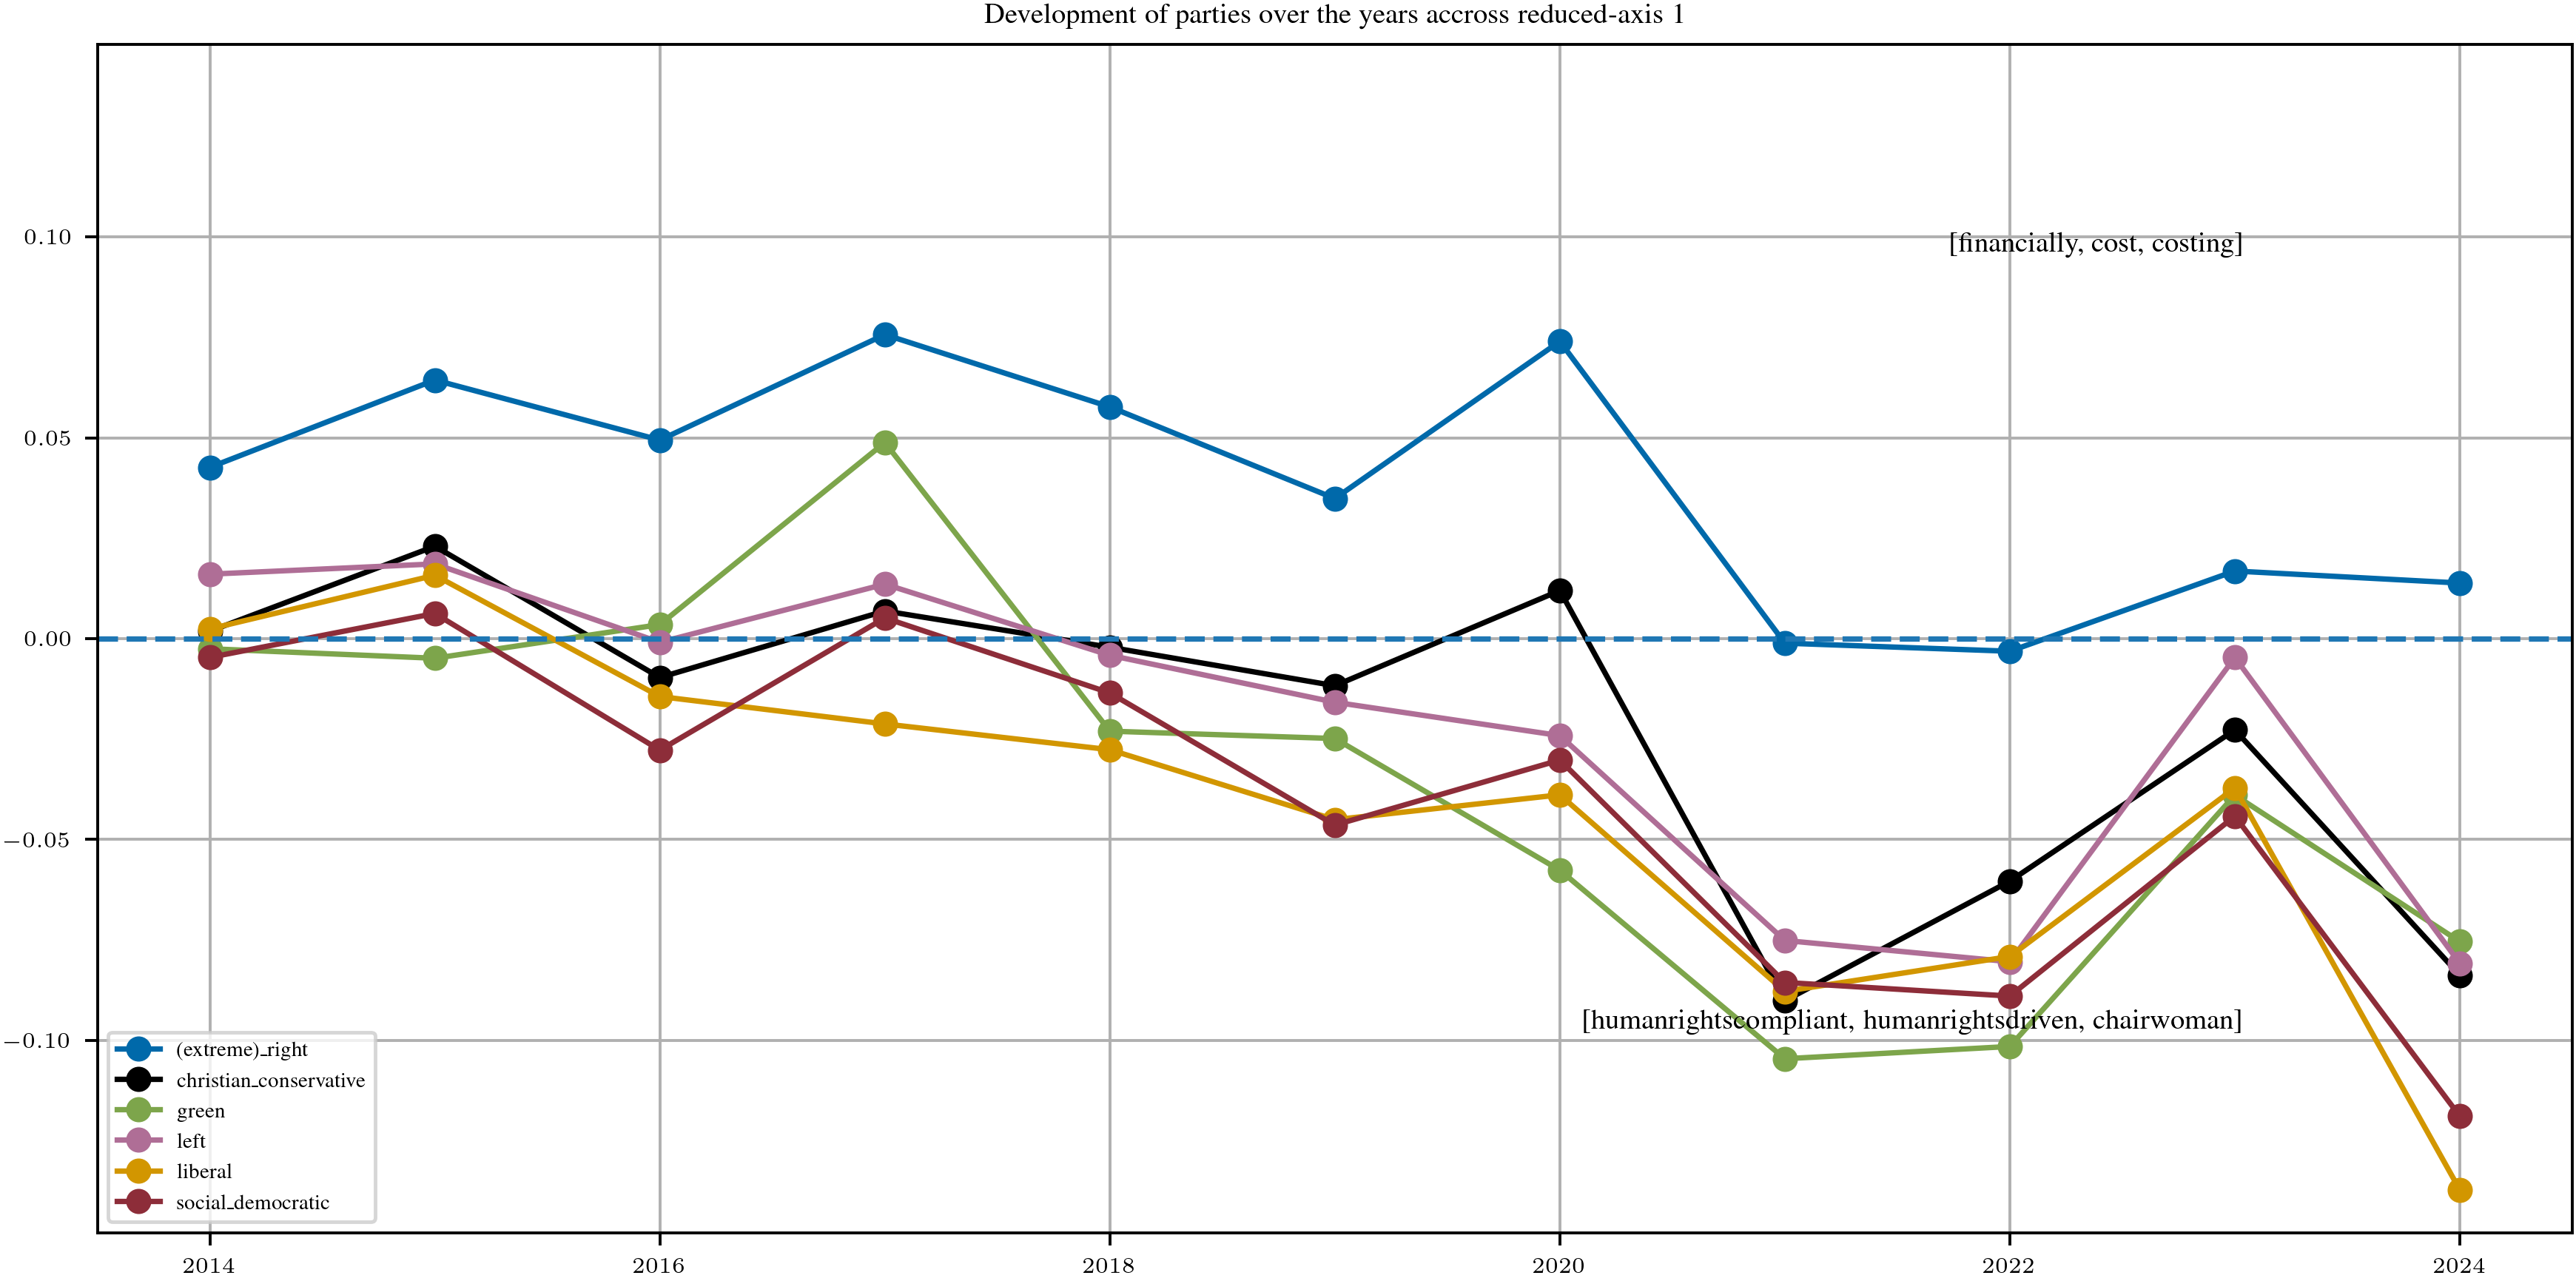

In [86]:
display_results(pca, axis[0], aggregated, vocab_df, 
                reduced_embeddings, aggregated_on, COLOR_MAPS[aggregated_on])

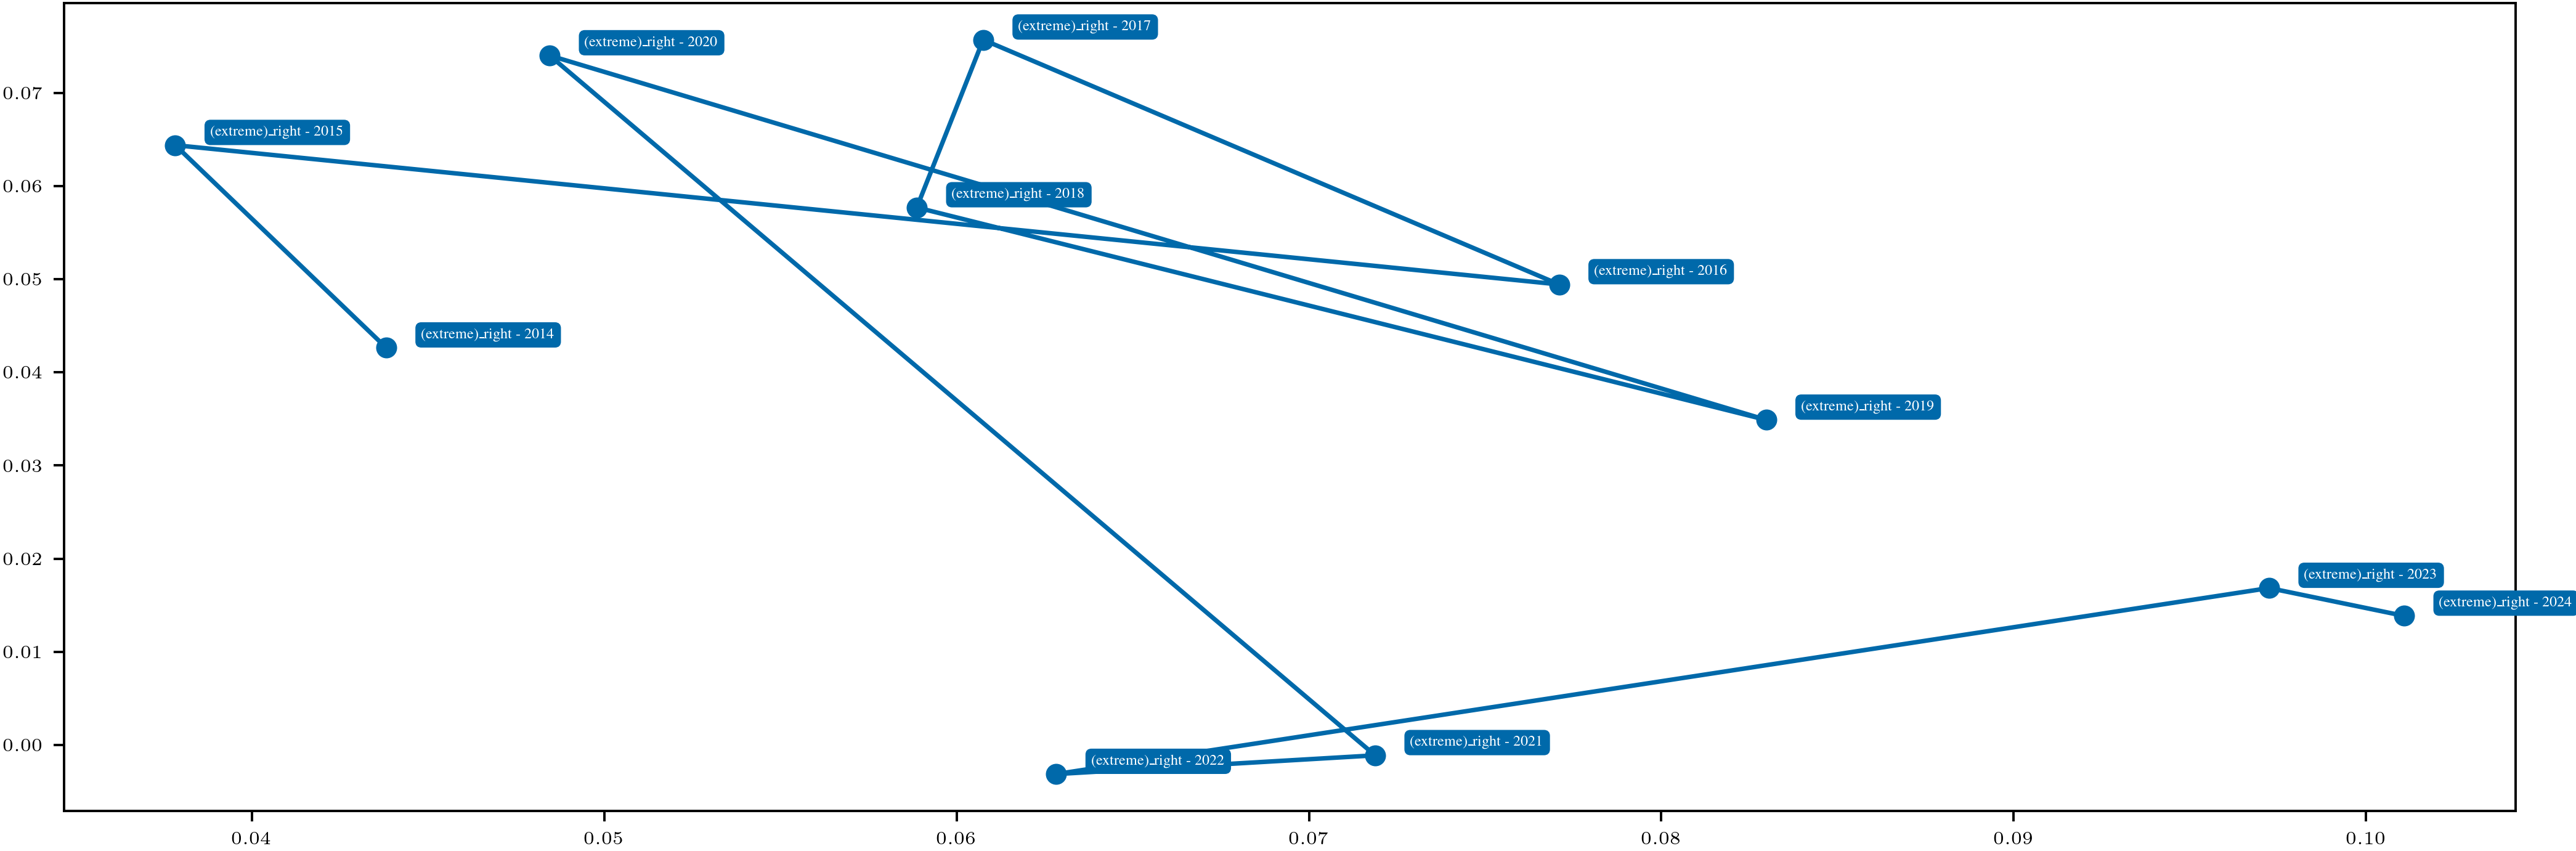

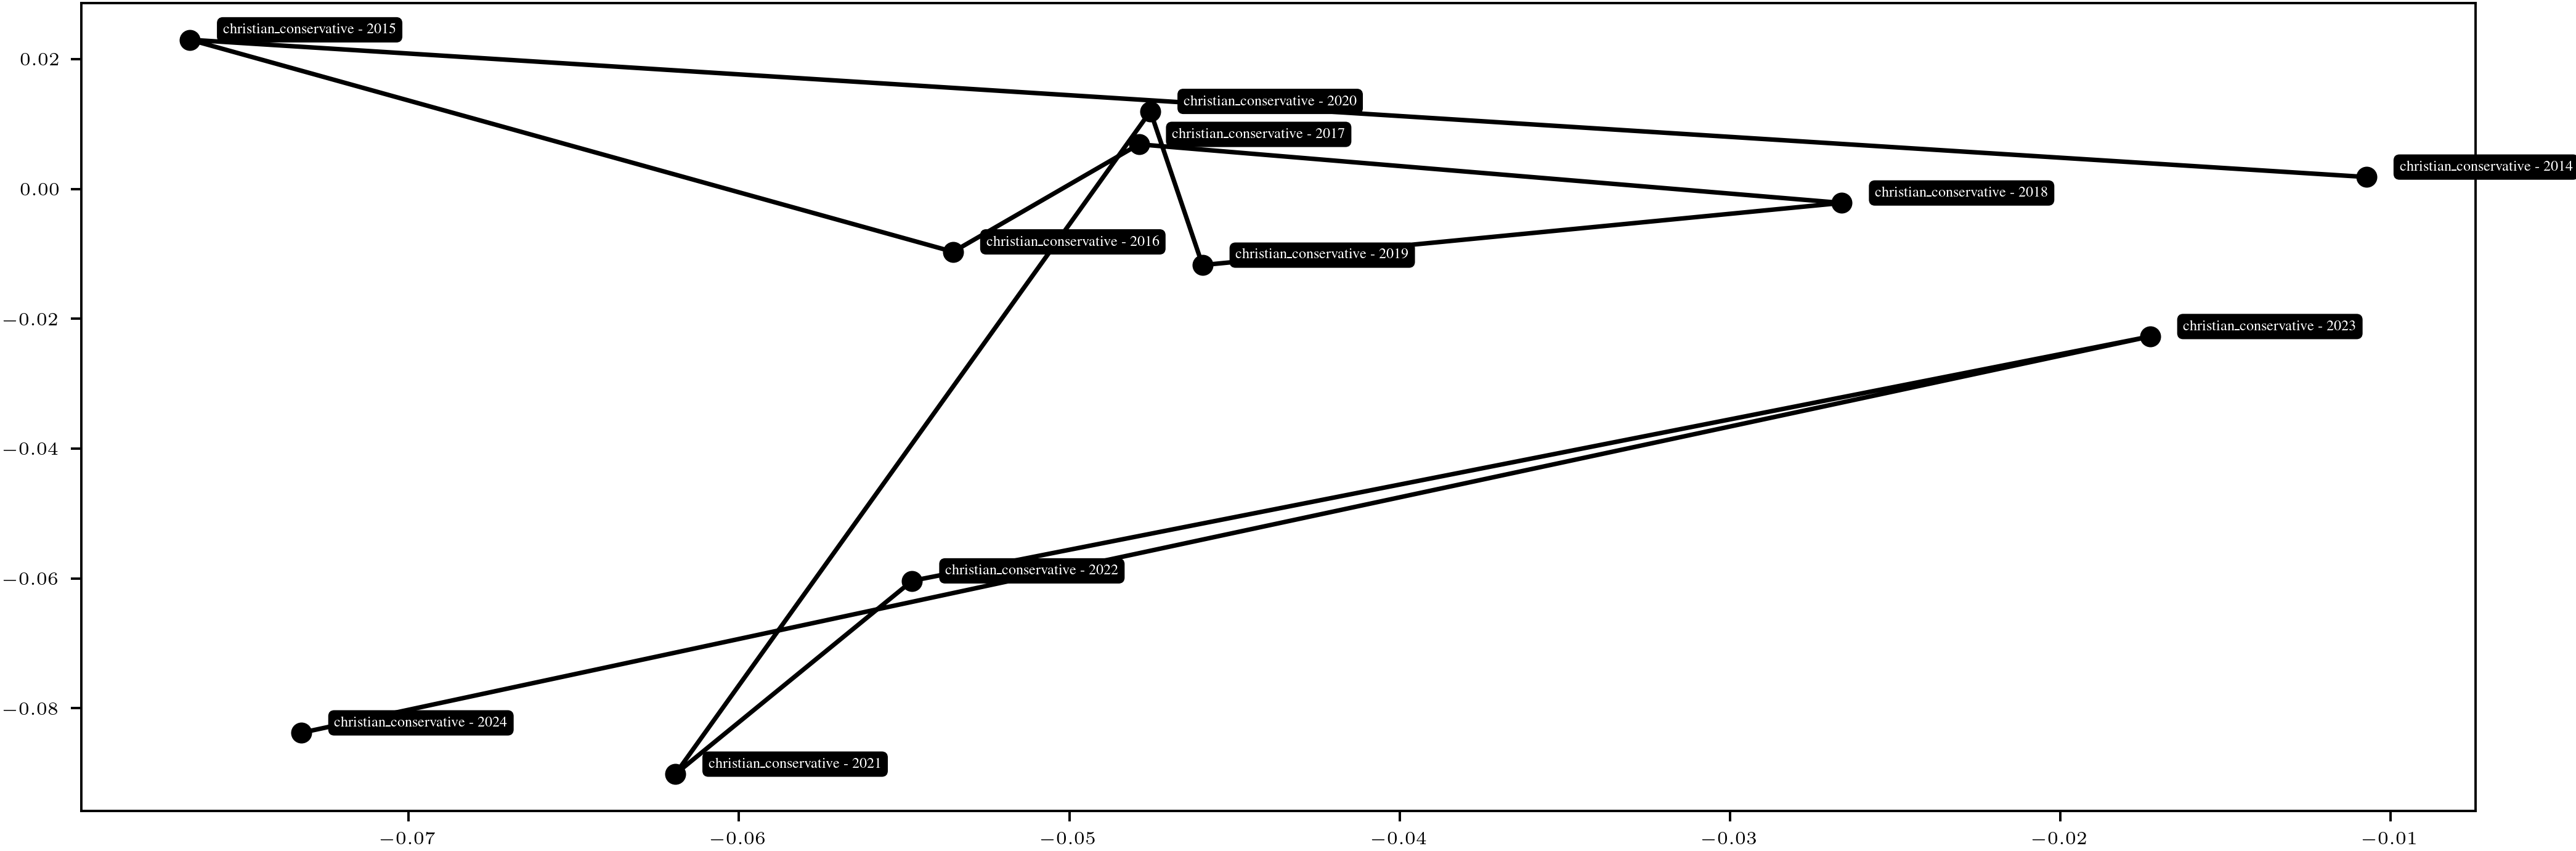

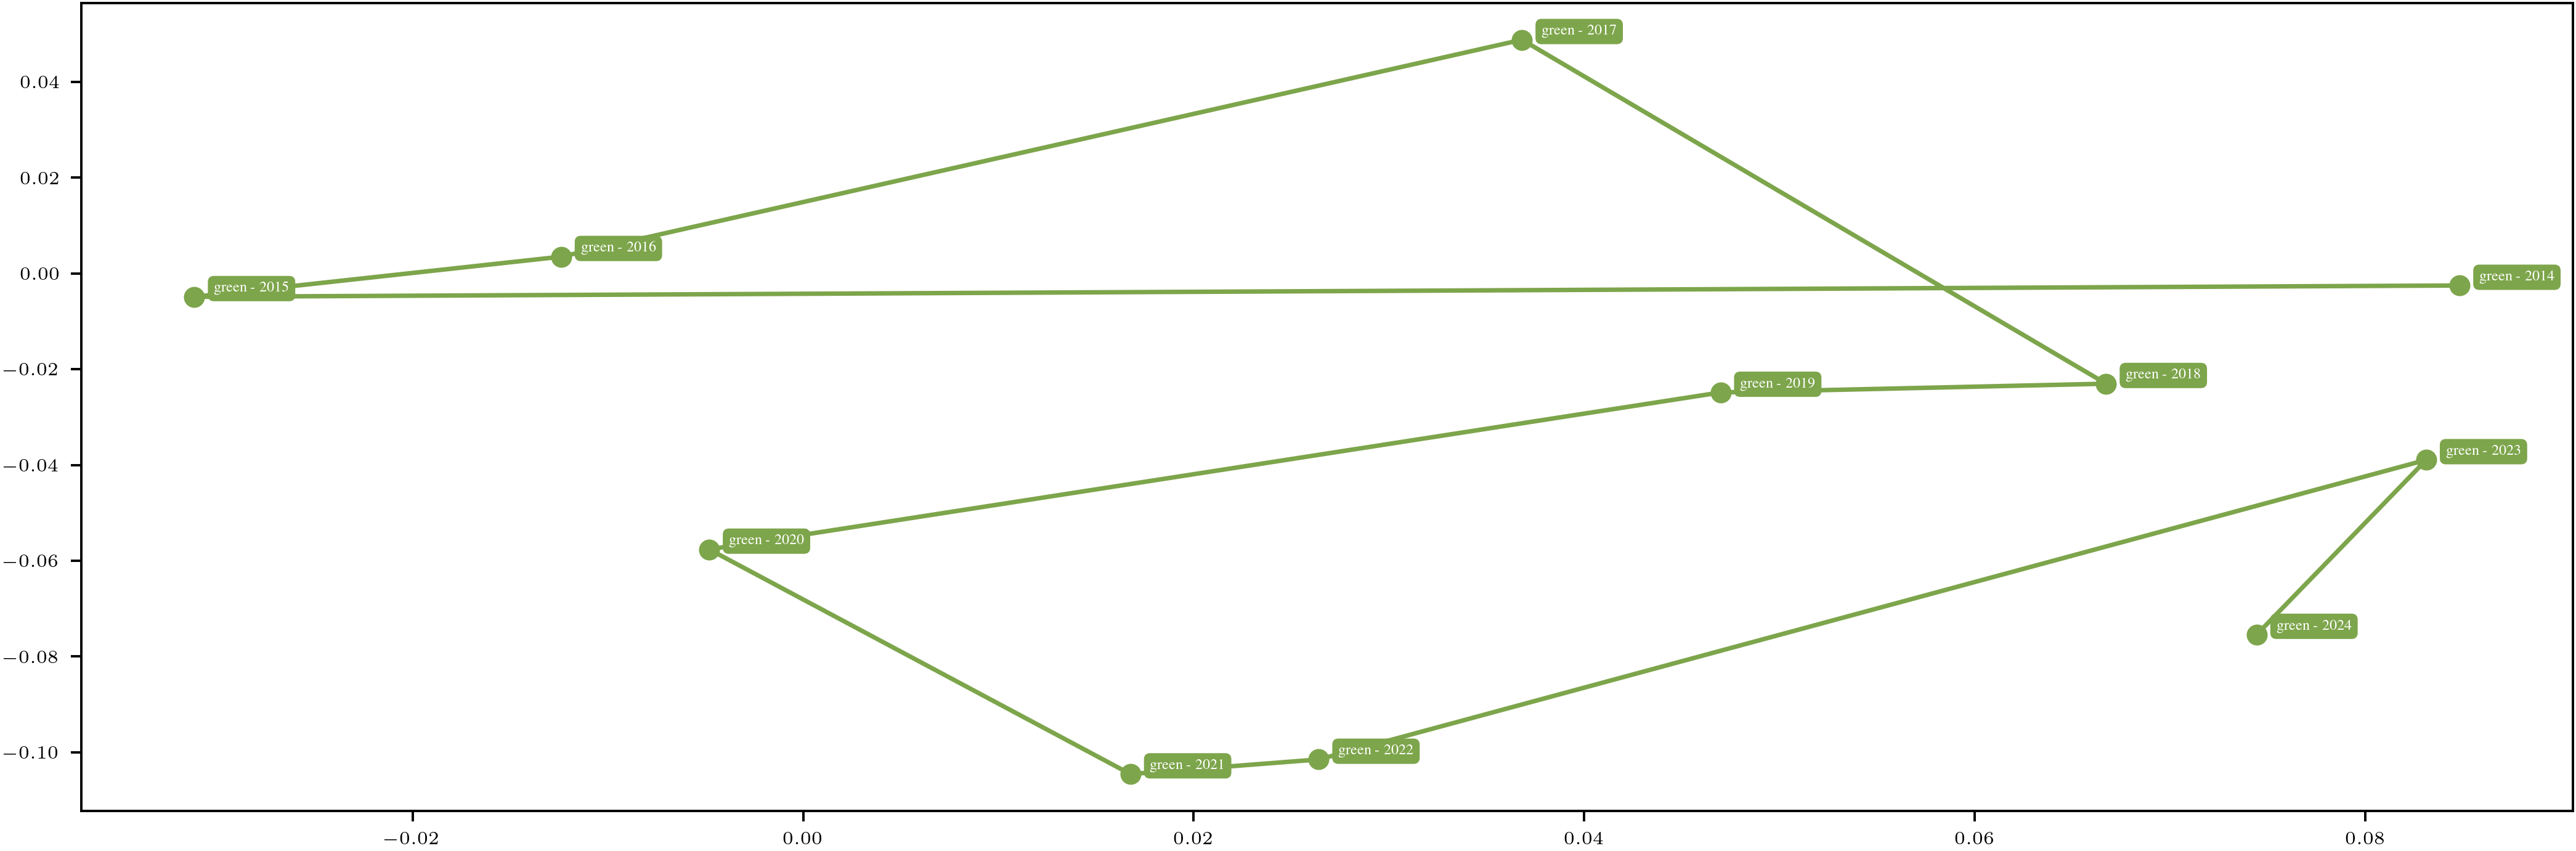

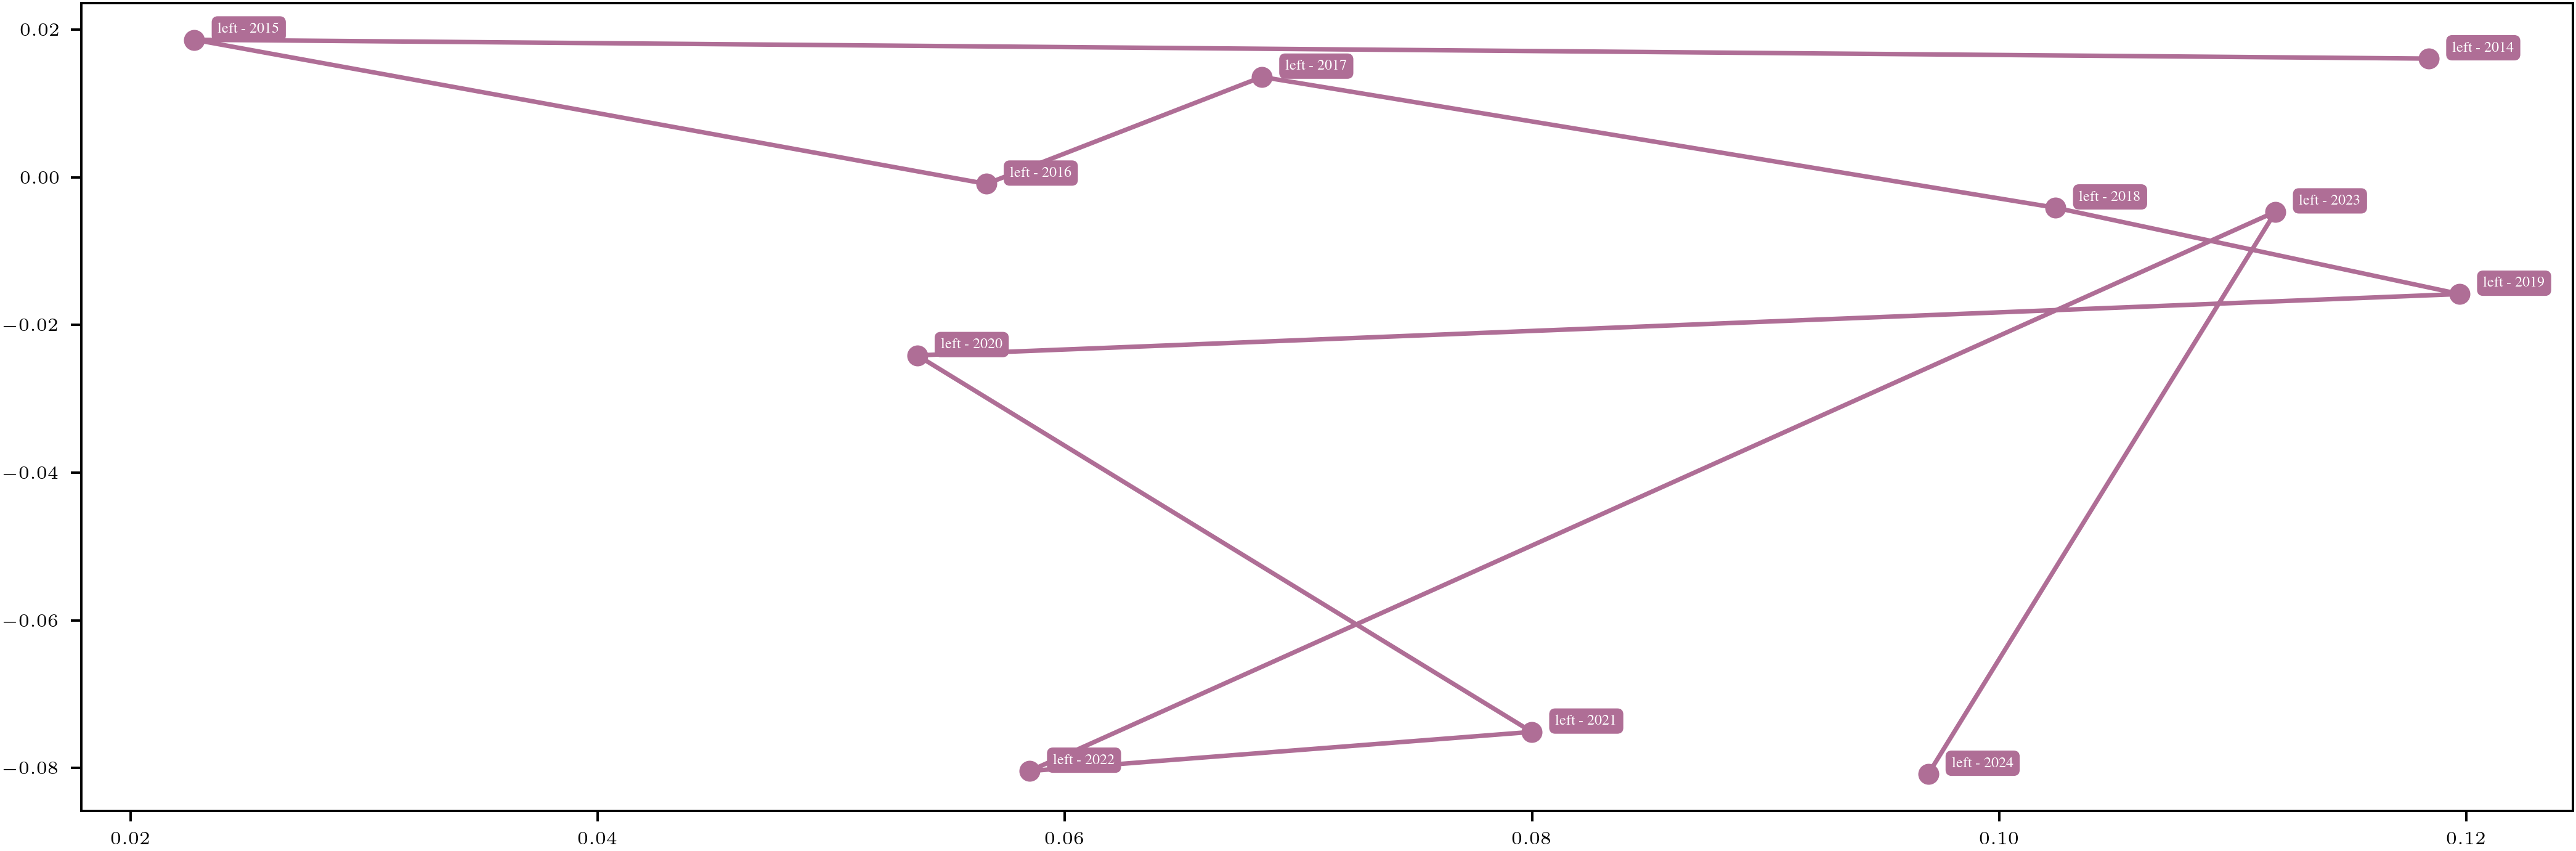

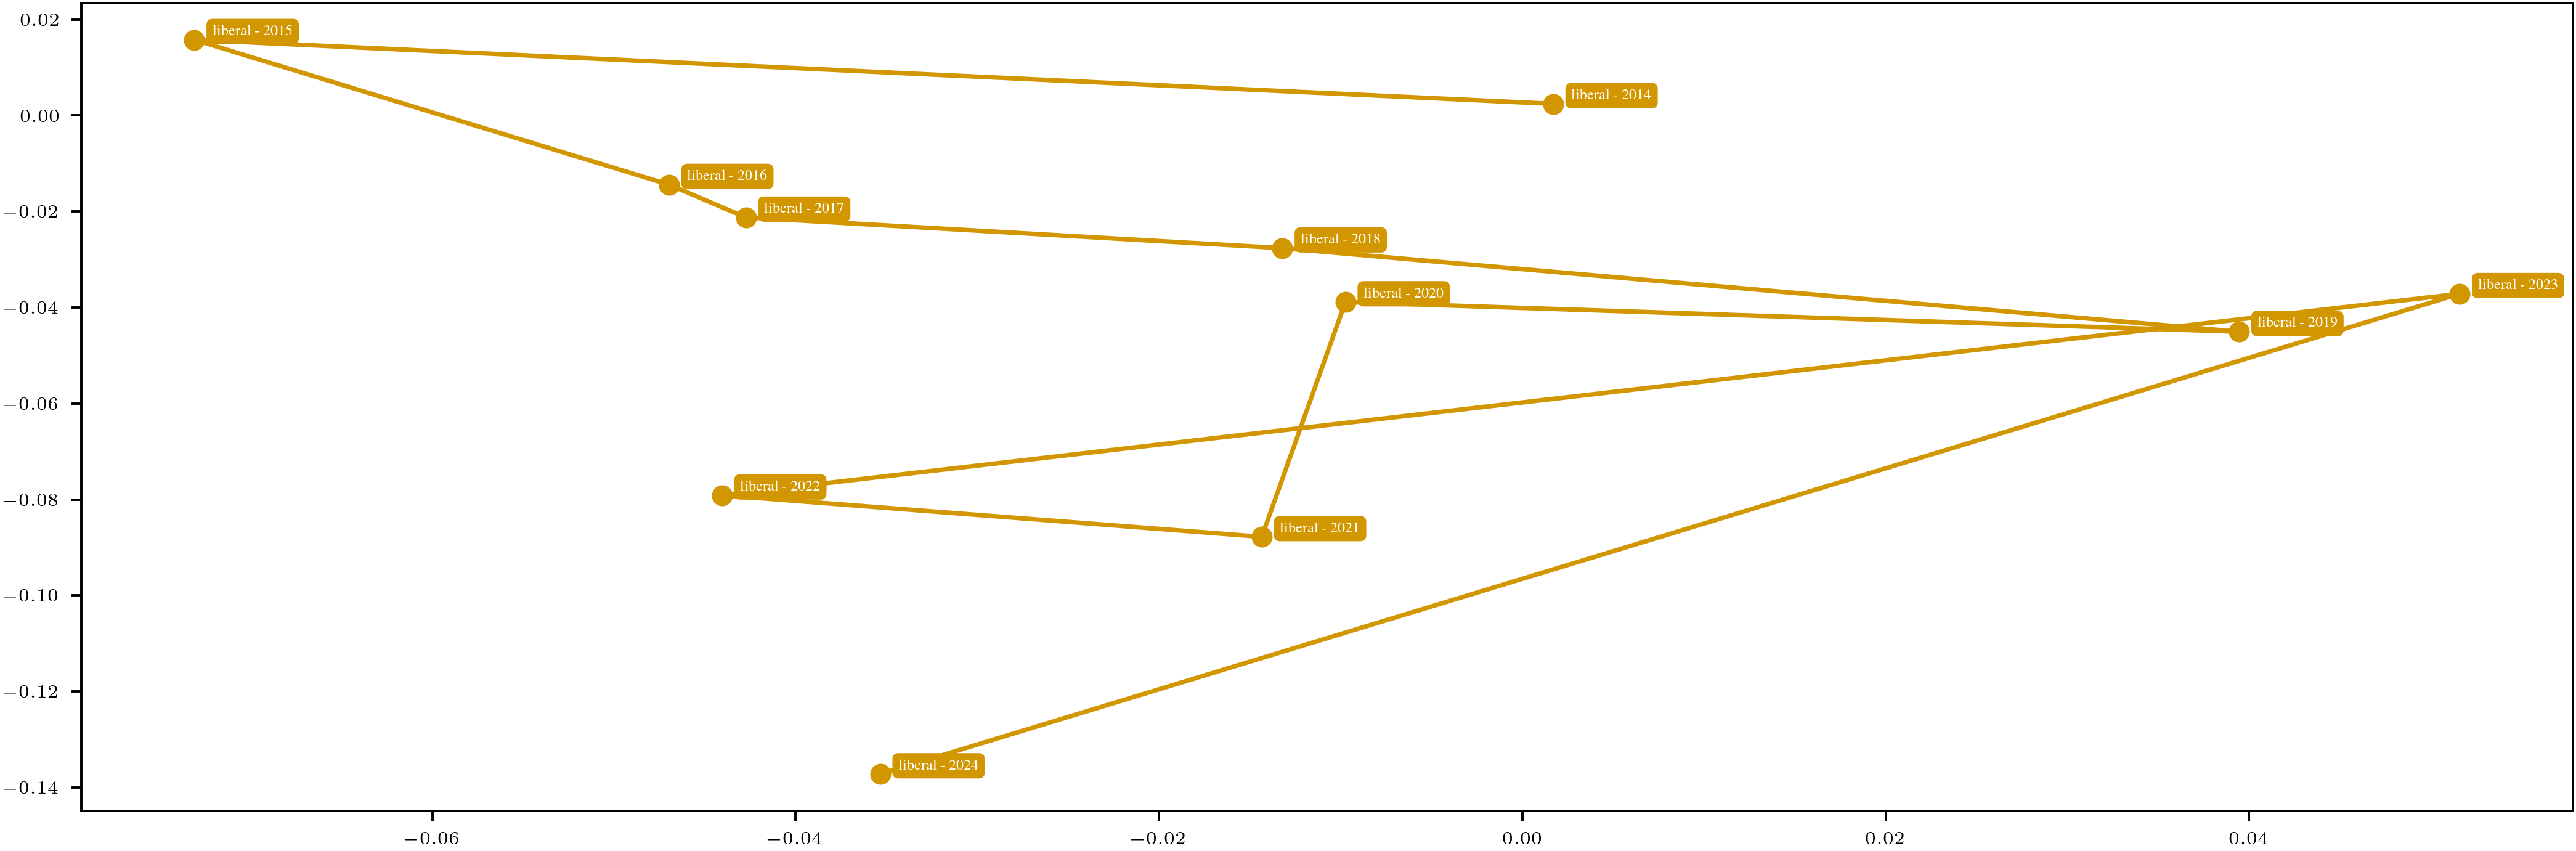

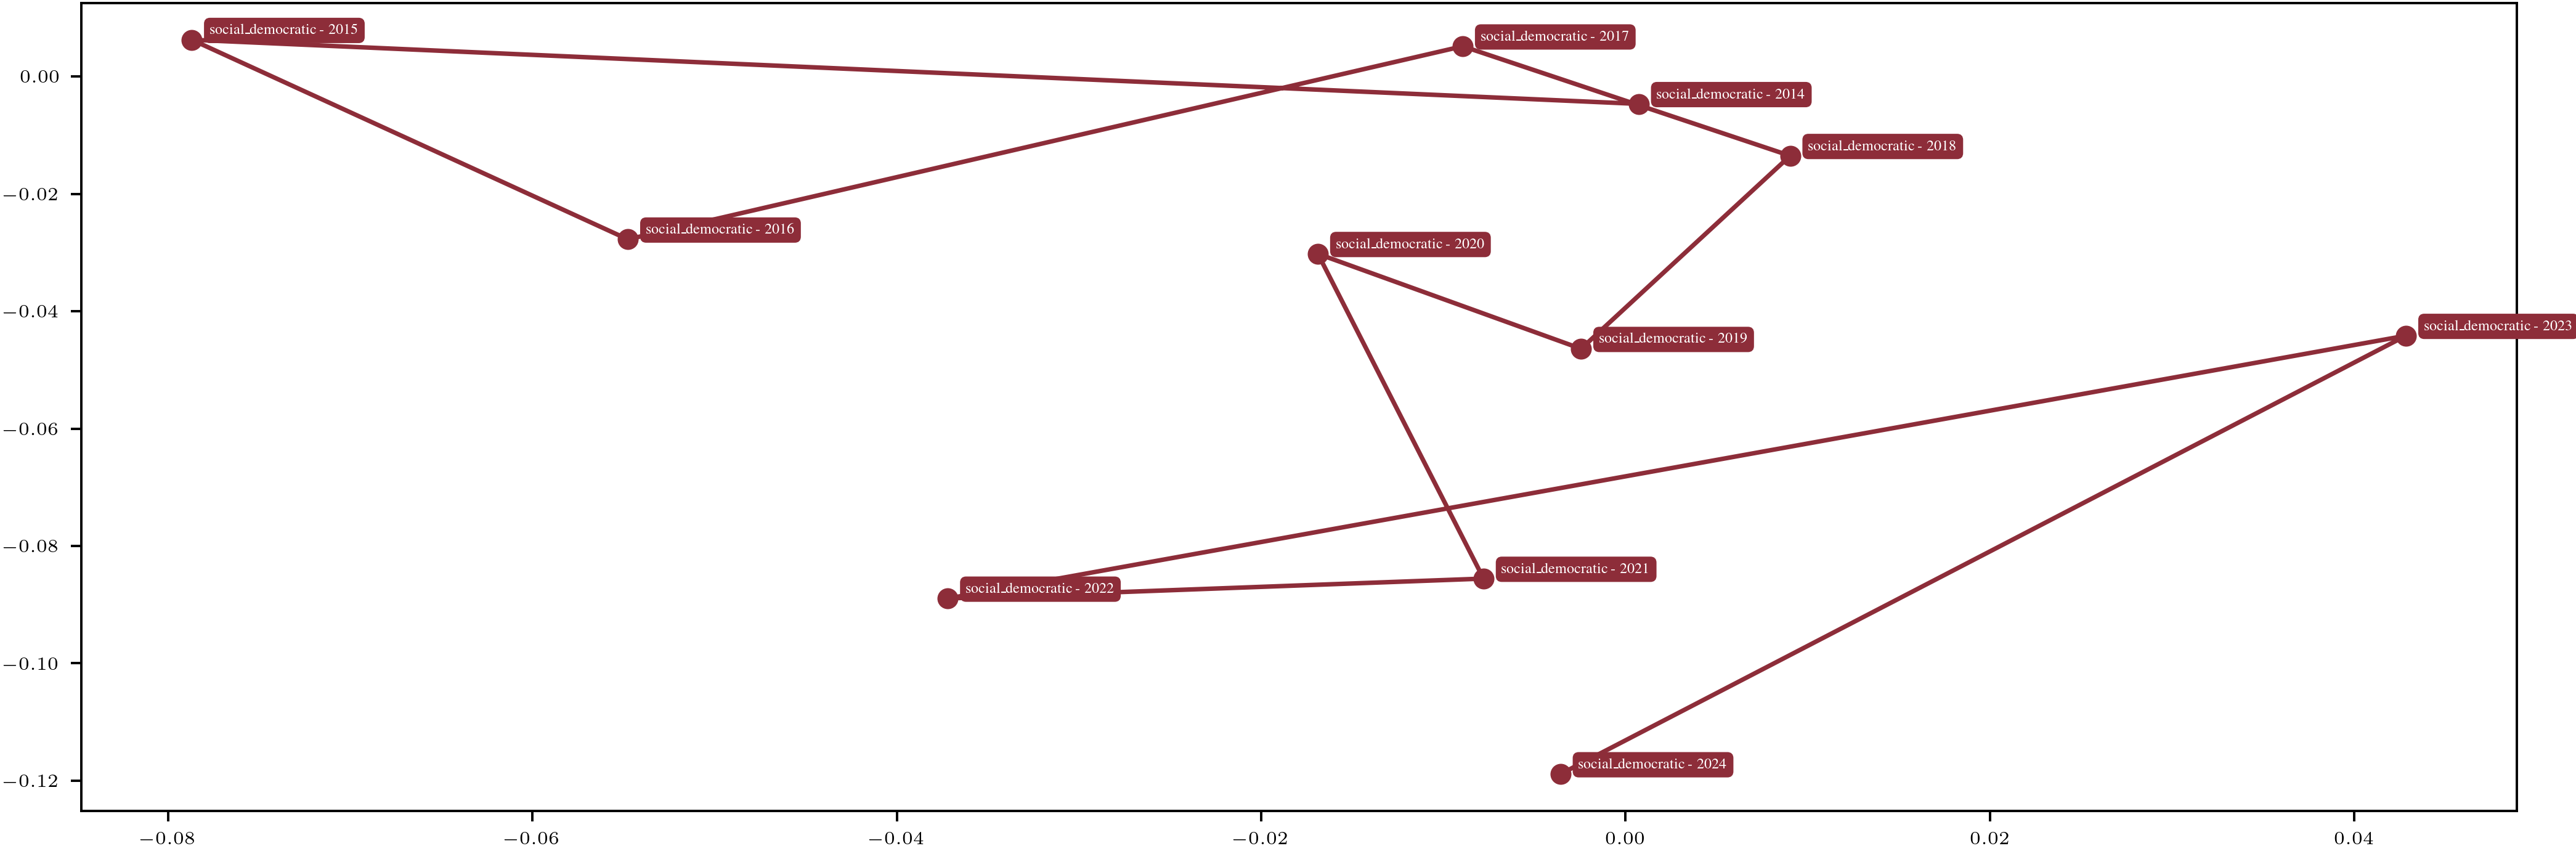

In [87]:
for party in aggregated[aggregated_on].unique():
    party_mask = aggregated[aggregated_on] == party
    years = aggregated[party_mask]['year']
    if len(years) < 2:
       continue
    fig, ax = plt.subplots(figsize=(12, 4))
    party_embeddings = reduced_embeddings[party_mask]
    ax.plot(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=COLOR_MAPS[aggregated_on][party])
    for i, year in enumerate(years):
      ax.text(party_embeddings[i,0]+0.001, party_embeddings[i,1]+0.001, f"{party} - {year}", fontsize=5, bbox=dict(boxstyle="round", color=COLOR_MAPS[aggregated_on][party]), color='white')
